In [1]:
from sklearn.base import BaseEstimator, ClassifierMixin
from lightgbm.sklearn import LGBMClassifier
import pandas as pd
import shap

In [524]:
def inv_logit(p):
    return np.exp(p) / (1 + np.exp(p))

class ShapZeroingClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, base_estimator):
        self.base_estimator = base_estimator
    
    def fit(self, X, y):
        self.classes_ = np.unique(y)
        self.base_estimator.fit(X, y)
        
    def predict(self, X):
        return np.argmax(self.predict_proba(X), axis=1)
    
    def predict_proba(self, X):
        try:
            explainer = shap.TreeExplainer(self.base_estimator)
            shap_values = explainer(X)
            base_values = shap_values.base_values
            shap_values = shap_values.values
        except:
            try:
#                 explainer = shap.TreeExplainer(self.base_estimator.base_estimator)
#                 shap_values = explainer(X)
#                 print('hey1')
                shap_values, base_values = self.base_estimator.shap_values(X)
#                 print('hey2')
#                 base_values = self.base_estimator.base_values(X)
#                 print('hey3')
            except:
                try:
                    shap_valueses = [shap.TreeExplainer(est)(X) for est in self.base_estimator.estimators_]
                    shap_values = np.mean([x.values for x in shap_valueses], axis=0)
                    base_values = np.mean([x.base_values for x in shap_valueses], axis=0)
                except:
                    explainer = shap.Explainer(self.base_estimator.predict_proba, masker=shap.maskers.Independent(X))
                    shap_values = explainer(X)
                    base_values = shap_values.base_values
                    shap_values = shap_values.values
        preds = inv_logit(base_values[:, 1] + ((~np.isnan(np.array(X)))*shap_values[:, :, 1]).sum(axis=1))
        return np.stack([1-preds, preds]).T

In [39]:
from sklearn.ensemble import BaggingClassifier
lgbm = LGBMClassifier(n_jobs=-1)
clf = BaggingClassifier(ShapZeroingClassifier(LGBMClassifier(n_jobs=-1, n_estimators=14, max_depth=1)), n_estimators=150)

In [40]:
clf.set_params(base_estimator__base_estimator__n_estimator=20)

BaggingClassifier(base_estimator=ShapZeroingClassifier(base_estimator=LGBMClassifier(max_depth=1,
                                                                                     n_estimator=20,
                                                                                     n_estimators=14)),
                  n_estimators=150)

In [41]:
import pandas as pd
ictcf = pd.read_pickle('../data/processed/ictcf.pkl')

In [470]:
from covidcf.evaluation.base import prepreprocess_data
from covidcf.config.base import load_config

In [471]:
conf = load_config('../experiments/within_dataset/ictcf/clinical/gbdt.yaml')

In [472]:
ictcf, X, y = prepreprocess_data(ictcf, conf)
y = y.cat.codes


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

In [441]:
X = ictcf.Input.copy()
y = ictcf.Target['pcr'].copy()

In [442]:
import re
import numpy as np
# for col in X.select_dtypes(include=['category']):
#     X[col] = X[col].cat.codes
#     X.loc[X[col] < 0, col] = np.nan
#     X[col] = X[col].astype('category')
# y = y.cat.codes
for col in X.select_dtypes(include=['category']):
    X[col] = X[col].cat.codes
    X.loc[X[col] < 0, col] = np.nan
    X[col] = X[col].astype('category')
X.columns = [re.sub(r'[^0-9a-zA-Z_-]+ ', '', '_'.join(col).strip()) for col in X.columns.values]
y = y.cat.codes

In [460]:
lgbm.fit(X, y)

LGBMClassifier()

In [3]:
from sklearn.metrics import roc_curve, precision_recall_curve
class BestThresholdClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, base_estimator, thresh_type='f1'):
        self.base_estimator = base_estimator
        self.thresh_type = thresh_type
        
    def fit(self, X, y):
        self.base_estimator.fit(X, y)
        if self.thresh_type == 'roc':
            fpr, tpr, thresholds = roc_curve(y, self.base_estimator.predict_proba(X)[:, 1])
            gmeans = np.sqrt(tpr * (1-fpr))
            self.threshold = thresholds[np.argmax(gmeans)]
        elif self.thresh_type == 'f1':
            precision, recall, thresholds = precision_recall_curve(y, self.base_estimator.predict_proba(X)[:, 1])
            fscore = (2 * precision * recall) / (precision + recall)
            self.threshold = thresholds[np.argmax(fscore)]
        return self
    
    def predict(self, X):
        return self.base_estimator.predict_proba(X)[:, 1] > self.threshold
    
    def predict_proba(self, X):
        return self.base_estimator.predict_proba(X)

In [444]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

In [474]:
X_train, y_train = X[ictcf.Meta.cohort == 'c1'], y[ictcf.Meta.cohort == 'c1']
X_test, y_test = X[ictcf.Meta.cohort == 'c2'], y[ictcf.Meta.cohort == 'c2']

In [483]:
from sklearn.metrics import f1_score, roc_auc_score
# b_clf = BaggingClassifier(TestTimeImputingClassifier(LGBMClassifier(n_jobs=-1), KNNImputer2(), n_repeat=30), n_estimators=20)
clf = BaggingClassifier(LGBMClassifier(n_jobs=-1), n_estimators=100)

# b_clf.fit(X_train, y_train)
clf.fit(X_train, y_train)
(clf.score(X_test, y_test), b_clf.score(X_test, y_test), 
    f1_score(y_test, clf.predict(X_test)), f1_score(y_test, b_clf.predict(X_test)), 
    roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1]), roc_auc_score(y_test, b_clf.predict_proba(X_test)[:, 1]))

(0.9002849002849003,
 0.7094017094017094,
 0.9309664694280079,
 0.779874213836478,
 0.9353484790142472,
 0.7318829418559876)

In [526]:
rumc = pd.read_pickle('../data/processed/rumc.pkl')

In [527]:
(~rumc[rumc.Meta.part == 'test'].Target.pcr.isna()).sum()

22

In [528]:
(~rumc[rumc.Meta.part != 'test'].Target.diagnosis.isna() | ~rumc[rumc.Meta.part != 'test'].Target.pcr.isna()).sum()

151

In [529]:
(~rumc[rumc.Meta.part != 'test'].Target.pcr.isna()).sum()

133

In [530]:
(~rumc.dropna(thresh=len(rumc)*0.16, axis=1)[~rumc.Target.pcr.isna()].isna()).sum()

Input   Clinical  AB0/RH. D BLOEDGROEP     69
                  ALAT                    133
                  ALBUMINE LKC             78
                  ALG. BACT. ONDERZ.      106
                  ALKALISCHE FOSFATASE    125
                                         ... 
                  age                     155
                  sex                     155
Target  pcr                               155
        corads                            153
Meta    part                              153
Length: 159, dtype: int64

In [9]:
X.dtypes.value_counts()

float64     121
category      5
int64         1
dtype: int64

In [10]:
lgbm.classes_

array([0, 1], dtype=int8)

In [11]:
# test_idx = ictcf.Meta.cohort == 'c2'
test_idx = ictcf.Meta.hospital == 'Union'
X_train, X_test = X.loc[~test_idx], X.loc[test_idx]
y_train, y_test = y.loc[~test_idx], y.loc[test_idx]

In [12]:
lgbm.fit(X_train, y_train)
clf.fit(X_train, y_train)

BaggingClassifier(base_estimator=ShapZeroingClassifier(base_estimator=LGBMClassifier(max_depth=1,
                                                                                     n_estimator=20,
                                                                                     n_estimators=14)),
                  n_estimators=150)

In [13]:
roc_auc_score(y_test, lgbm.predict_proba(X_test)[:, 1]), roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])

NameError: name 'roc_auc_score' is not defined

In [ ]:
from sklearn.model_selection import cross_val_score, StratifiedKFold
cross_val_score(lgbm, X, y, cv=StratifiedKFold(10, shuffle=True), scoring='roc_auc').mean(), cross_val_score(clf, X, y, cv=StratifiedKFold(10, shuffle=True), scoring='roc_auc').mean()

In [1094]:
from sklearn.base import clone
class TestTimeImputingClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, base_estimator, imputer, n_repeat, ensemble=False, impute_in_predict=False):
        self.base_estimator = base_estimator
        self.imputer = imputer
        self.n_repeat = n_repeat
        self.ensemble = ensemble
        self.impute_in_predict = impute_in_predict
        
        if ensemble:
            self._estimators = []
    
    def _impute_data(self, X, y, should_fit):
        X_rep = []
        if y is not None:
            y_rep = []
            
        imputer = self.imputer
        if isinstance(self.imputer, ColumnImputer) and self.impute_in_predict and not should_fit:
            imputer = self.predict_imputer

        if should_fit:
            imputer.fit(X)

        for i in range(self.n_repeat):
            X_rep.append(imputer.transform(X))
            if y is not None:
                y_rep.append(y)

        X_rep = pd.concat([pd.DataFrame(x) for x in X_rep])
        if y is not None:
            y_rep = pd.concat([pd.Series(y) for y in y_rep])
            return X_rep, y_rep
        else:
            return X_rep
    
    def fit(self, X, y):
        self.classes_ = np.unique(y)
        if not self.impute_in_predict:
            if isinstance(self.imputer, IterativeImputer):
                self.imputer.sample_posterior = True
            elif isinstance(self.imputer, ColumnImputer):
#                 self.predict_imputer = SimpleImputer(strategy='mean').fit(X, y)
                self.predict_imputer = IterativeImputer(max_iter=30, n_nearest_features=60).fit(X, y)
            elif isinstance(self.imputer, KNNImputer2):
                self.predict_imputer = KNNImputer(n_neighbors=self.imputer.n_neighbors).fit(X, y)
        else:
            if isinstance(self.imputer, ColumnImputer):
                self.predict_imputer = IterativeImputer(max_iter=18, n_nearest_features=16, sample_posterior=True).fit(X, y)
        X_rep, y_rep = self._impute_data(X, y, should_fit=True)
        if self.ensemble:
            n_samples = X.shape[0]
            self._estimators = []
            for i in range(self.n_repeat):
                X_i, y_i = X_rep[n_samples*i:n_samples*(i+1)], y_rep[n_samples*i:n_samples*(i+1)]
                estimator = clone(self.base_estimator)
                estimator.fit(X_i, y_i)
                self._estimators.append(estimator)
        else:
            self.base_estimator.fit(X_rep, y_rep)
        
    def predict(self, X):
        return np.argmax(self.predict_proba(X), axis=1)
    
    def predict_proba(self, X):
        if not self.impute_in_predict:
            if isinstance(self.imputer, IterativeImputer):
                self.imputer.sample_posterior = False
                return self.base_estimator.predict_proba(self.imputer.transform(X))
            elif isinstance(self.imputer, ColumnImputer):
                if not self.ensemble:
                    return self.base_estimator.predict_proba(self.predict_imputer.transform(X))
                else:
                    X_imputed = self.predict_imputer.transform(X)
                    return np.mean([est.predict_proba(X_imputed) for est in self._estimators], axis=0)
            elif isinstance(self.imputer, KNNImputer2):
                if not self.ensemble:
                    return self.base_estimator.predict_proba(self.predict_imputer.transform(X))
                else:
                    X_imputed = self.predict_imputer.transform(X)
                    return np.mean([est.predict_proba(X_imputed) for est in self._estimators], axis=0)
        
        if self.impute_in_predict:
            X_rep = self._impute_data(X, None, should_fit=False)
        
#         print(np.array([preds[n_preds*i:n_preds*(i+1)] for i in range(self.n_repeat)]).shape)
        if self.ensemble:
            n_samples = X.shape[0]
            if self.impute_in_predict:
                return np.mean([est.predict_proba(X_rep[n_samples*i:n_samples*(i+1)]) for i, est in enumerate(self._estimators)], axis=0)
            else:
                return np.mean([est.predict_proba(X) for i, est in enumerate(self._estimators)], axis=0)
        else:
            preds = self.base_estimator.predict_proba(X_rep)
            n_preds = X.shape[0]
            return np.mean([preds[n_preds*i:n_preds*(i+1)] for i in range(self.n_repeat)], axis=0)
    
    def shap_values(self, X):
        X_rep = self._impute_data(X, None, should_fit=False)
        n_preds = X.shape[0]
        explainer = shap.TreeExplainer(self.base_estimator)
        shap_values = [explainer(X_rep[n_preds*i:n_preds*(i+1)]) for i in range(self.n_repeat)]
        return np.mean([s.values for s in shap_values], axis=0), np.mean([s.base_values for s in shap_values], axis=0)
    
    def base_values(self, X):
        X_rep = self._impute_data(X, None, should_fit=False)
        n_preds = X.shape[0]
        explainer = shap.TreeExplainer(self.base_estimator)
        return np.mean([explainer(X_rep[n_preds*i:n_preds*(i+1)]).base_values for i in range(self.n_repeat)], axis=0)

In [715]:
from sklearn.base import clone
class ReducedModel(BaseEstimator, ClassifierMixin):
    def __init__(self, base_estimator):
        self.base_estimator = base_estimator
        
        self._estimators = {}
        self.X_train = None
        self.y_train = None
    
    
    def fit(self, X, y):
        self.X_train = np.array(X)
        self.y_train = np.array(y)
        self._estimators = {}
        
    def predict(self, X):
        return np.argmax(self.predict_proba(X), axis=1)
    
    def predict_proba(self, X):
        X = np.array(X)
        preds = []
        for i in range(X.shape[0]):
            row = X[i, :]
            present_idx = list(np.where(~np.isnan(row))[0])
            X_train_sub = self.X_train[:, present_idx]
            if frozenset(present_idx) in self._estimators:
                estimator = self._estimators[frozenset(present_idx)]
            else:
                estimator = clone(self.base_estimator)
                estimator.fit(X_train_sub, self.y_train)
                self._estimators[frozenset(present_idx)] = estimator
            preds.append(estimator.predict_proba(row[None, present_idx]))
        return np.concatenate(preds)
    
#     def shap_values(self, X):
#         X_rep = self._impute_data(X, None, should_fit=False)
#         n_preds = X.shape[0]
#         explainer = shap.TreeExplainer(self.base_estimator)
#         shap_values = [explainer(X_rep[n_preds*i:n_preds*(i+1)]) for i in range(self.n_repeat)]
#         return np.mean([s.values for s in shap_values], axis=0), np.mean([s.base_values for s in shap_values], axis=0)
    
#     def base_values(self, X):
#         X_rep = self._impute_data(X, None, should_fit=False)
#         n_preds = X.shape[0]
#         explainer = shap.TreeExplainer(self.base_estimator)
#         return np.mean([explainer(X_rep[n_preds*i:n_preds*(i+1)]).base_values for i in range(self.n_repeat)], axis=0)

In [700]:
np.concatenate([np.array([1, 2, 3, 4])[None, [0, 1, 3]], np.array([1, 2, 3, 4])[None, [0, 1, 3]]])

array([[1, 2, 4],
       [1, 2, 4]])

In [566]:
iter_imp = IterativeImputer(sample_posterior=False)
X_train_sampled = iter_imp.fit_transform(X_train)

In [567]:
iter_imp.sample_posterior = False

In [568]:
X_train_mean = iter_imp.transform(X_train)

In [569]:
(X_train_sampled == X_train_mean).all()

True

In [401]:
from sklearn.base import clone
class RandomDropClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, base_estimator, n_repeat, drop_completely_randomly=True, drop_rate=0.3, impute_in_predict=True, ensemble=False):
        self.base_estimator = base_estimator
        self.n_repeat = n_repeat
        self.ensemble = ensemble
        self.impute_in_predict = impute_in_predict
        self.drop_completely_randomly = drop_completely_randomly
        self.drop_rate = drop_rate
    
    def _random_drop(self, X, y):
        X_rep = []
        if y is not None:
            y_rep = []
        
        if isinstance(X, pd.DataFrame):
            n_missing_total = X.isnull().sum().mean()
        else:
            n_missing_total = np.isnan(X).sum(axis=0).mean()
        for i in range(self.n_repeat):
            X_copy = X.copy()
            if isinstance(X_copy, pd.DataFrame):
                if self.drop_completely_randomly:
                    to_drop = np.random.rand(*X.shape) <= self.drop_rate
                    X_copy.values[to_drop] = np.nan
                else:
                    for col in X.columns:
                        n_missing = X[col].isna().sum()
                        n_remove = int(n_missing_total - n_missing)
                        if n_remove >= 0:
                            indices_to_remove = np.random.choice(X[~X[col].isna()].index, n_remove, replace=False)
                            X_copy.loc[indices_to_remove, col] = np.nan
                        else:
                            indices_to_add = np.random.choice(X[X[col].isna()].index, -n_remove, replace=False)
                            values_to_add = np.random.choice(~X[X[col].isna()].values, -n_remove, replace=True)
                            X_copy.loc[indices_to_add, col] = values_to_add
            else:
                if self.drop_completely_randomly:
                    to_drop = np.random.rand(*X.shape) <= self.drop_rate
                    X_copy[to_drop] = np.nan
                else:
                    for i in range(X.shape[1]):
                        n_missing = np.isnan(X[:, i]).sum()
                        n_remove = int(n_missing_total - n_missing)
                        if n_remove >= 0:
                            indices_to_remove = np.random.choice(np.where(~np.isnan(X[:, i]))[0], n_remove, replace=False)
                            X_copy[indices_to_remove, i] = np.nan
                        else:
                            if np.isnan(X[:, i]).sum() != len(X[:, i]):
                                indices_to_add = np.random.choice(np.where(np.isnan(X[:, i]))[0], -n_remove, replace=False)
                                values_to_add = np.random.choice(X[~np.isnan(X[:, i]), i], -n_remove, replace=True)
                                X_copy[indices_to_add, i] = values_to_add
                            
            X_rep.append(X_copy)
            if y is not None:
                y_rep.append(y)

        X_rep = pd.concat([pd.DataFrame(x) for x in X_rep])
        if y is not None:
            y_rep = pd.concat([pd.Series(y) for y in y_rep])
            return X_rep, y_rep
        else:
            return X_rep
    
    def fit(self, X, y):
        self.classes_ = np.unique(y)
        X_rep, y_rep = self._random_drop(X, y)
        if self.ensemble:
            n_samples = X.shape[0]
            self._estimators = []
            for i in range(self.n_repeat):
                X_i, y_i = X_rep[n_samples*i:n_samples*(i+1)], y_rep[n_samples*i:n_samples*(i+1)]
                estimator = clone(self.base_estimator)
                estimator.fit(X_i, y_i)
                self._estimators.append(estimator)
        else:
            self.base_estimator.fit(X_rep, y_rep)
        
    def predict(self, X):
        return np.argmax(self.predict_proba(X), axis=1)
    
    def predict_proba(self, X):
        if self.impute_in_predict:
            X_rep = self._random_drop(X, None)
        
#         print(np.array([preds[n_preds*i:n_preds*(i+1)] for i in range(self.n_repeat)]).shape)
        if self.ensemble:
            n_samples = X.shape[0]
            if self.impute_in_predict:
                return np.mean([est.predict_proba(X_rep[n_samples*i:n_samples*(i+1)]) for i, est in enumerate(self._estimators)], axis=0)
            else:
                return np.mean([est.predict_proba(X) for i, est in enumerate(self._estimators)], axis=0)
        else:
            if self.impute_in_predict:
                preds = self.base_estimator.predict_proba(X_rep)
                n_preds = X.shape[0]
                return np.mean([preds[n_preds*i:n_preds*(i+1)] for i in range(self.n_repeat)], axis=0)
            else:
                return self.base_estimator.predict_proba(X)
    
    def shap_values(self, X):
        X_rep = self._impute_data(X, None, should_fit=False)
        n_preds = X.shape[0]
        explainer = shap.TreeExplainer(self.base_estimator)
        shap_values = [explainer(X_rep[n_preds*i:n_preds*(i+1)]) for i in range(self.n_repeat)]
        return np.mean([s.values for s in shap_values], axis=0), np.mean([s.base_values for s in shap_values], axis=0)
    
    def base_values(self, X):
        X_rep = self._impute_data(X, None, should_fit=False)
        n_preds = X.shape[0]
        explainer = shap.TreeExplainer(self.base_estimator)
        return np.mean([explainer(X_rep[n_preds*i:n_preds*(i+1)]).base_values for i in range(self.n_repeat)], axis=0)

In [394]:
from sklearn.base import TransformerMixin
class ColumnImputer(TransformerMixin):
    def fit(self, X, y=None):
        if isinstance(X, pd.DataFrame):
            self.options = {col: X[col].dropna().values for col in X.columns}
        else:
            self.options = {i: X[:, i][~np.isnan(X[:, i])] for i in range(X.shape[1])}
        return self
    
    def transform(self, X, y=None):
        X = X.copy()
        if isinstance(X, pd.DataFrame):
            for col in X.columns:
                if len(self.options[col]) > 0:
                    X.loc[X[col].isna(), col] = np.random.choice(self.options[col], size=X[col].isna().sum())
                else:
                    X.loc[X[col].isna(), col] = 0
        else:
            for i in range(X.shape[1]):
                if len(self.options[i]) > 0:
#                     print(np.isnan(X[:, i]).sum())
                    X[np.isnan(X[:, i]), i] = np.random.choice(self.options[i], size=len(X[np.isnan(X[:, i]), i]))
#                     print(np.isnan(X[:, i]).sum())
                    assert np.isnan(X[:, i]).sum() == 0
                else:
#                     assert np.all(np.isnan(X[:, i]))
                    X[np.isnan(X[:, i]), i] = 0
            
#         if isinstance(X, pd.DataFrame):
#             for col in X.columns:
#                 if X[col].isna().all():
# #                     X = X.drop(columns=[col])
#                     X[col] = 0
#         else:
# #             idx = []
#             for i in range(X.shape[1]):
#                 if np.all(np.isnan(X[:, i])):
# #                     idx.append(i)
#                     X[:, i] = 0
#             X = np.delete(X, idx, axis=1)
#         print(type(X))
#         if np.any(np.isnan(X)):
#             print(np.any(np.isnan(X), axis=1))
#             print(X)
        assert not np.any(np.isnan(np.array(X)))
        return X

In [278]:
from sklearn.base import TransformerMixin
class RandomImputer(TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        X = X.copy()
        if isinstance(X, pd.DataFrame):
            for col in X.columns:
                if X[col].isna().sum() > 0:
                    X.loc[X[col].isna(), col] = np.random.uniform(low=np.nanpercentile(X.values, 1), high=np.nanpercentile(X.values, 99), size=X[col].isna().sum())
        else:
            for i in range(X.shape[1]):
                if np.isnan(X[:, i]).sum() > 0:
                    X[np.isnan(X[:, i]), i] = np.random.uniform(low=np.nanpercentile(X, 1), high=np.nanpercentile(X, 99), size=np.isnan(X[:, i]).sum())
                    
        assert not np.any(np.isnan(X))
        return X

In [162]:
RandomImputer().fit_transform(pd.DataFrame(np.array([
    [1, 1, np.nan], 
    [1, np.nan, -2]
])))

,0,1,2
0,1.0,1.000000,-1.503949
1,1.0,0.026378,-2.000000


In [405]:
# explicitly require this experimental feature
from sklearn.experimental import enable_iterative_imputer  # noqa
# now you can import normally from sklearn.impute
from sklearn.impute import IterativeImputer, SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import BaggingClassifier
# clf = BaggingClassifier(TestTimeImputingClassifier(LGBMClassifier(n_jobs=-1), ColumnImputer(), n_repeat=800), n_estimators=100)
# clf = BaggingClassifier(TestTimeImputingClassifier(LogisticRegression(), ColumnImputer(), n_repeat=50))
# clf = BaggingClassifier(LGBMClassifier(n_jobs=-1), n_estimators=30)

# clf = make_pipeline(IterativeImputer(), LGBMClassifier(n_jobs=-1))
# clf = ShapZeroingClassifier(make_pipeline(SimpleImputer(), LogisticRegression()))
clf = RandomDropClassifier(LGBMClassifier(n_jobs=-1), 200, ensemble=True, drop_rate=0.5, drop_completely_randomly=False, impute_in_predict=False)
# clf = TestTimeImputingClassifier(LGBMClassifier(n_jobs=-1), IterativeImputer(), n_repeat=100)
# clf = TestTimeImputingClassifier(LGBMClassifier(n_jobs=-1), ColumnImputer(), n_repeat=1000, ensemble=True)
# clf = LGBMClassifier(n_jobs=-1)

In [406]:
clf.fit(X_train, y_train)

In [407]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])

0.0

In [7]:
def impute_data(X, y, negative_pattern, positive_pattern):
    for i in range(X.shape[1]):
        if np.random.rand() < negative_pattern[i]:
            X[y == 0, i] = np.nan
        
        if np.random.rand() < positive_pattern[i]:
            X[y == 1, i] = np.nan

In [952]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_breast_cancer
X, y = load_breast_cancer(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)
neg_pattern = np.random.rand(X.shape[1])
pos_pattern = np.random.rand(X.shape[1])

In [9]:
impute_data(X_train, y_train, neg_pattern, pos_pattern)
impute_data(X_test, y_test, pos_pattern, neg_pattern)

In [20]:
clf.fit(X_train, y_train)

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


In [435]:
roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])

0.7736742424242424

In [310]:
roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])

0.0

In [10]:
from sklearn.base import BaseEstimator, ClassifierMixin
import numpy as np
from sklearn.datasets import load_breast_cancer
from lightgbm.sklearn import LGBMClassifier
from bonsai.base.c45tree import C45Tree
import seaborn as sns
import matplotlib.pyplot as plt
from typing import List, Any

In [11]:
from numba import njit, prange, jit
@njit(fastmath=True)
def gini_impurity(X: np.ndarray):
    result = 0
    classes = np.unique(X[:, -1])
    for c in classes:
        result += ((X[:, -1]==c).sum()/X.shape[0])**2
    return 1 - result

@njit(fastmath=True)
def gini_index(Xs: List[np.ndarray]):
#     total_size = np.sum(np.array([X.shape[0] for X in Xs]))
    total_size = 0
    for X in Xs:
        total_size += X.shape[0]
    if total_size == 0:
        return 1
    result = 0
    for X in Xs:
        result += X.shape[0]/total_size * gini_impurity(X)
    return result
#     return np.sum([X.shape[0]/total_size * gini_impurity(X) for X in Xs])

In [12]:
@njit
def split_data(X: np.ndarray, feature_index: int, split_value: float):
    is_na = np.isnan(X[:, feature_index])
    left = X[(X[:, feature_index] < split_value) | is_na]
    right = X[(X[:, feature_index] >= split_value) | is_na]
    return left, right

In [13]:
@njit
def generate_split_points(X: np.ndarray, feature_index: int):
    splits = np.sort(X[:, feature_index])
    return set(splits[~np.isnan(splits)])

In [14]:
from dataclasses import dataclass
from numba.experimental import jitclass
from typing import Union
from numba import int32, float32, deferred_type

@dataclass
class Leaf:
    value: int
    n_samples: int

# leaf_spec = [
#     ('value', int32), 
#     ('n_samples', int32)
# ]

# @jitclass(leaf_spec)
# class Leaf:
#     def __init__(self, value, n_samples):
#         self.value = value
#         self.n_samples = n_samples


@dataclass
class Tree:
    left: Union['Tree', Leaf]
    right: Union['Tree', Leaf]
    split_feature: int
    split_value: float
    n_samples: int

# leaf_type = deferred_type()
# leaf_type.define(Leaf.class_type.instance_type)

# tree_spec = [
#     ('left', leaf_type), 
#     ('right', leaf_type), 
#     ('split_feature', int32), 
#     ('split_value', float32), 
#     ('n_samples', int32)
# ]

# @jitclass(tree_spec)
# class Tree:
#     def __init__(self, left, right, split_feature, split_value, n_samples):
#         self.left = left
#         self.right = right
#         self.split_feature = split_feature
#         self.split_value = split_value
#         self.n_samples = n_samples

In [15]:
@njit(fastmath=True)
def get_split(X: np.ndarray):
    best_gini, best_feature, best_split, best_groups = np.inf, None, None, None
    for feature_index in range(X.shape[1]-1):
        for split_value in generate_split_points(X, feature_index):
            groups = split_data(X, feature_index, split_value)
            gini = gini_index(groups)
            if gini < best_gini:
                best_gini = gini
                best_feature = feature_index
                best_split = split_value
                best_groups = groups
    current_gini = gini_impurity(X)
    if current_gini < best_gini:
        return 0, 0, 0, (None, None)
    return best_feature, best_split, best_gini, best_groups

In [16]:
# @njit
# def most_frequent(a: np.ndarray):
#     values, counts = np.unique(a, return_counts=True)
#     ind = np.argmax(counts)
#     return values[ind]

@njit
def most_frequent(x):
    return np.argmax(np.bincount(x.astype(np.int32)))

In [17]:
@jit
def test(X, last_gini, t):
    if np.sum(X) < 10:
        return (last_gini, 3, 3)
    else:
        return t

In [18]:
test.signatures

[]

In [19]:
# @jit()
def decision_tree(X: np.ndarray, last_gini=None):
    best_feature, best_split, best_gini, (left, right) = get_split(X)
    if left is None or last_gini == best_gini:
        return Leaf(most_frequent(X[:, -1]), X.shape[0])
    
    if len(np.unique(left[:, -1])) == 1:
        left_tree = Leaf(most_frequent(left[:, -1]), left.shape[0])
    elif len(np.unique(left[:, -1])) == 0:
        left_tree = Leaf(most_frequent(X[:, -1]), 1)
    else:
        left_tree = decision_tree(left, last_gini=best_gini)
    
    if len(np.unique(right[:, -1])) == 1:
        right_tree = Leaf(most_frequent(right[:, -1]), right.shape[0])
    elif len(np.unique(right[:, -1])) == 0:
        right_tree = Leaf(most_frequent(X[:, -1]), 1)
    else:
        right_tree = decision_tree(right, last_gini=best_gini)
    
    return Tree(left_tree, right_tree, best_feature, best_split, X.shape[0])

In [20]:
# @jit
# def decision_tree(X: np.ndarray, last_gini=None):
#     best_feature, best_split, best_gini, (left, right) = get_split(X)
#     if left is None or last_gini == best_gini:
#         return (most_frequent(X[:, -1]), X.shape[0])
    
#     if len(np.unique(left[:, -1])) == 1:
#         left_tree = (most_frequent(left[:, -1]), left.shape[0])
#     elif len(np.unique(left[:, -1])) == 0:
#         left_tree = (most_frequent(X[:, -1]), 1)
#     else:
#         left_tree = decision_tree(left, last_gini=best_gini)
    
#     if len(np.unique(right[:, -1])) == 1:
#         right_tree = (most_frequent(right[:, -1]), right.shape[0])
#     elif len(np.unique(right[:, -1])) == 0:
#         right_tree = (most_frequent(X[:, -1]), 1)
#     else:
#         right_tree = decision_tree(right, last_gini=best_gini)
    
#     return Tree(None, , left_tree, right_tree, best_feature, best_split)

In [21]:
def predict(tree: Union[Tree, Leaf], sample: np.ndarray):
    if isinstance(tree, Leaf):
        return tree.value
    
    if sample[tree.split_feature] < tree.split_value:
        return predict(tree.left, sample)
    elif np.isnan(sample[tree.split_feature]):
        total_samples = tree.left.n_samples + tree.right.n_samples
        return (predict(tree.left, sample)*tree.left.n_samples + predict(tree.right, sample)*tree.right.n_samples)/total_samples
    
    return predict(tree.right, sample)

In [22]:
class DecisionTree(BaseEstimator, ClassifierMixin):
    def __init__(self, random_state=0):
        pass
    
    def fit(self, data, labels):
        self.tree = decision_tree(np.concatenate([data, labels[:, None]], axis=1))
    
    def predict(self, data):
        return np.array([np.round(predict(self.tree, data[i, :])) for i in range(data.shape[0])])

In [23]:
from scipy.stats import mode
class RandomForest(BaseEstimator, ClassifierMixin):
    def __init__(self, n_trees=10):
        self.n_trees = n_trees
        
    def _boostrap_data(self, data):
        return data[np.random.choice(data.shape[0], size=data.shape[0]), :]
    
    def fit(self, data, labels):
        self.trees = [decision_tree(self._boostrap_data(np.concatenate([data, labels[:, None]], axis=1))) 
                      for i in range(self.n_trees)]
        
    def _predict_single(self, row):
        return mode([np.round(predict(t, row)) for t in self.trees]).mode
    
    def predict(self, data):
        return np.array([self._predict_single(data[i, :]) for i in range(data.shape[0])])

In [24]:
def impute_data(X, y, negative_pattern, positive_pattern):
    for i in range(X.shape[1]):
        X[(y == 0) & (np.random.rand(X.shape[0]) < negative_pattern[i]), i] = np.nan
        X[(y == 1) & (np.random.rand(X.shape[0]) < positive_pattern[i]), i] = np.nan

In [491]:
X_copy, y_copy = X.copy(), y.copy()
neg_pattern = np.random.rand(X.shape[1])
pos_pattern = np.random.rand(X.shape[1])
impute_data(X_copy, y_copy, neg_pattern, pos_pattern)

In [492]:
np.isnan(X_copy).sum(axis=0), neg_pattern

(array([384, 458, 220, 245, 253, 483, 432, 326, 407, 177, 150, 253, 188,
        106, 522, 308, 263, 242, 267, 383, 192, 194, 385,  82, 428, 282,
        292, 284, 368, 493]),
 array([0.38280071, 0.6895965 , 0.57984366, 0.36070945, 0.97061999,
        0.78948519, 0.91622906, 0.96820042, 0.99302204, 0.45603686,
        0.40965184, 0.56466605, 0.76239833, 0.10686026, 0.87841767,
        0.19341828, 0.81027492, 0.25013801, 0.62197162, 0.72005137,
        0.39467824, 0.44231057, 0.59932314, 0.36323011, 0.86206444,
        0.93795491, 0.15560415, 0.12500054, 0.49668408, 0.78447898]))

<AxesSubplot:>

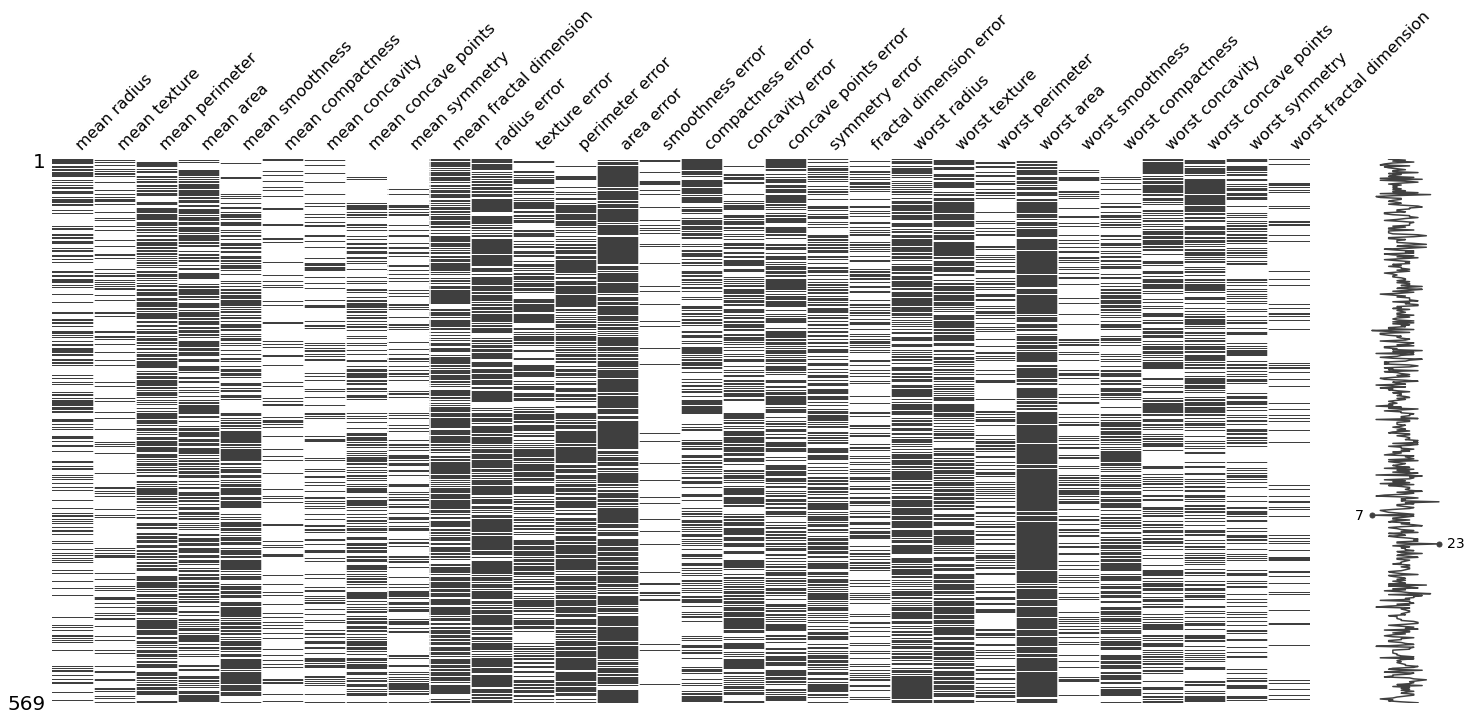

In [493]:
import missingno
missingno.matrix(pd.DataFrame(X_copy, columns=load_breast_cancer(return_X_y=True, as_frame=True)[0].columns))

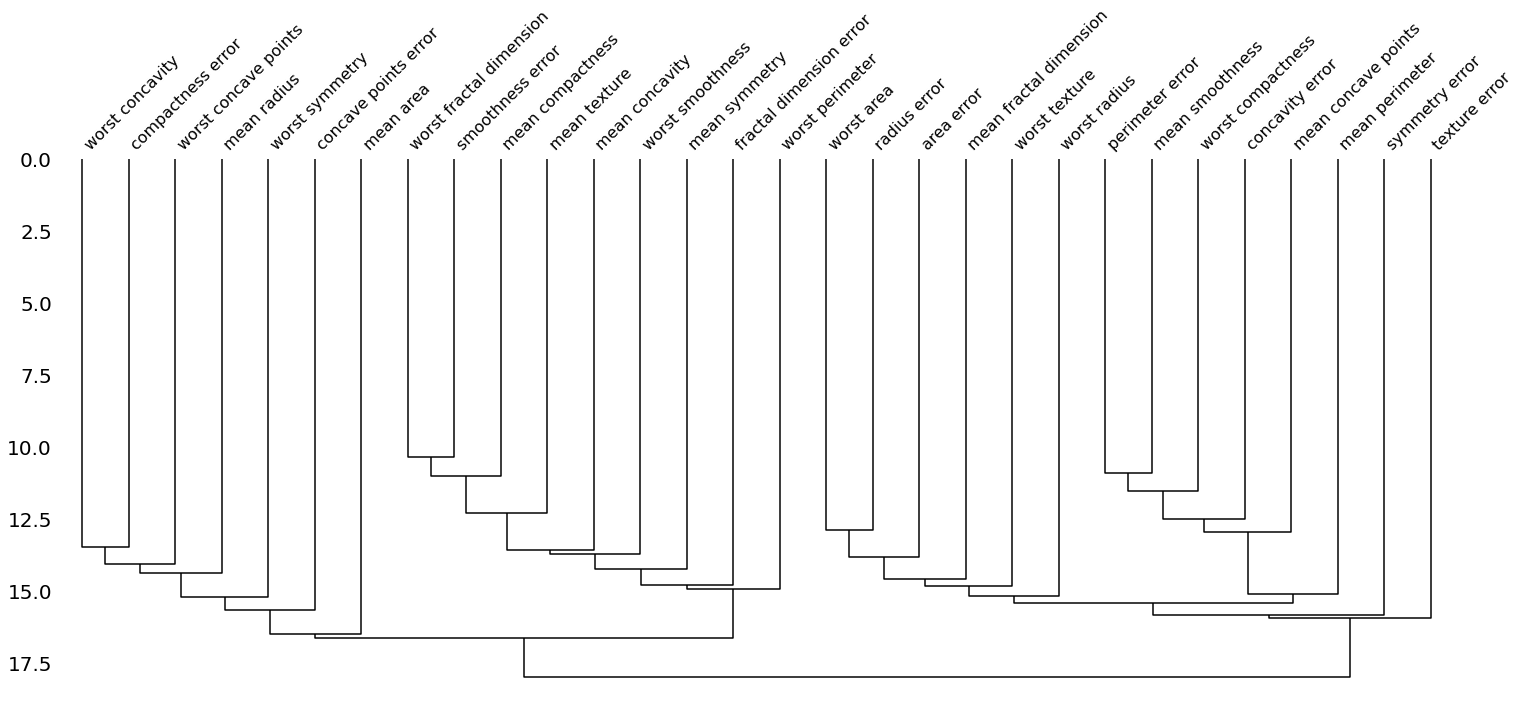

In [494]:
missingno.dendrogram(pd.DataFrame(X_copy, columns=load_breast_cancer(return_X_y=True, as_frame=True)[0].columns))
plt.savefig('dengrogram_synthetic.pdf')

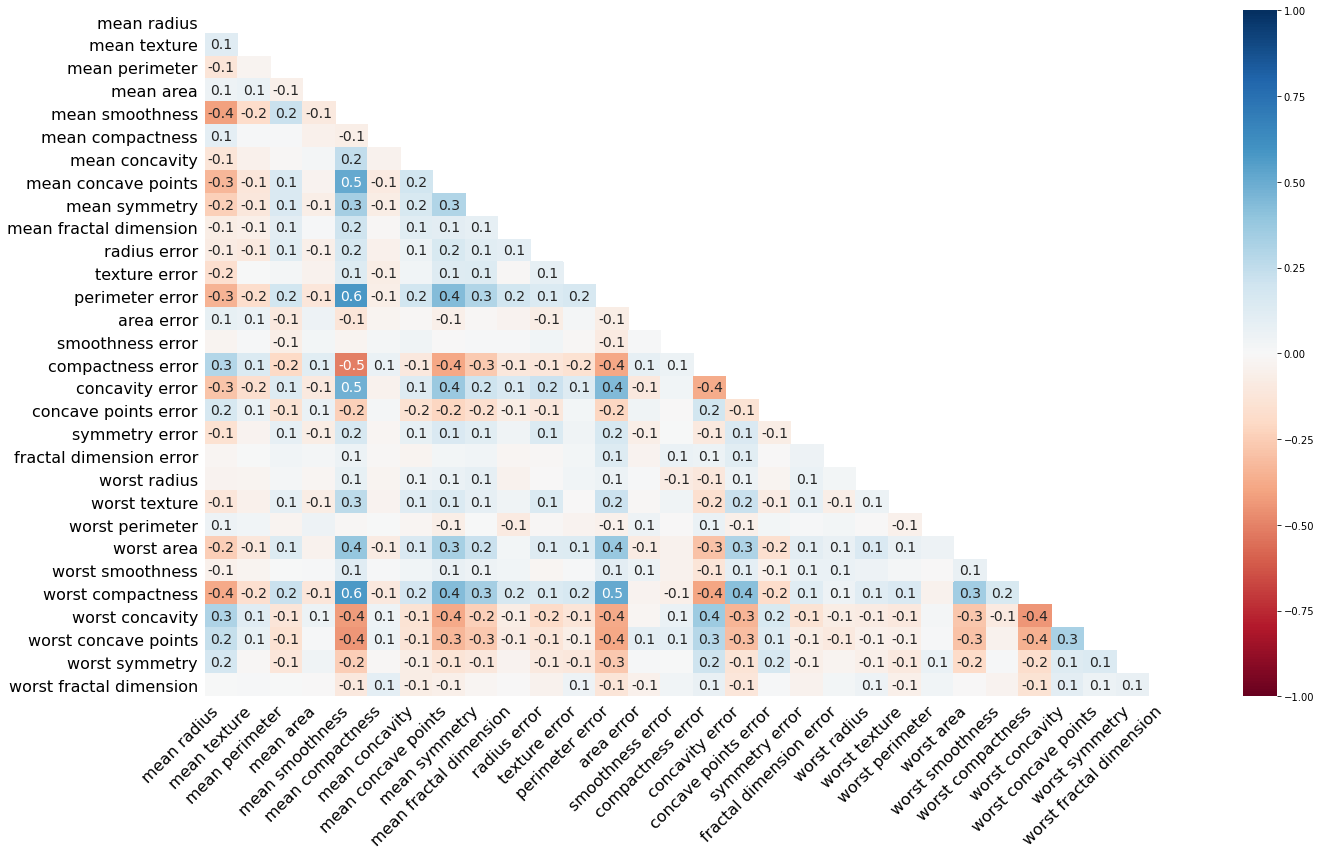

In [1111]:
import missingno
missingno.heatmap(pd.DataFrame(X_copy, columns=load_breast_cancer(return_X_y=True, as_frame=True)[0].columns))
plt.tight_layout()
plt.savefig('missing_heatmap_synthetic.pdf')

In [1006]:
import pandas as pd
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
X, y = load_breast_cancer(return_X_y=True)
def compare_models(models, n_trials, prev, complete_random=False, rand_indicative_feature=False):
    results = []
    for i in tqdm(range(n_trials)):
        if not complete_random:
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)
        else:
#             X_rand, y_rand = np.random.rand(*X.shape), np.random.rand(*y.shape) < 0.5
#             if rand_indicative_feature:
#                 idx = np.random.randint(X.shape[1])
#                 X_rand[y==1, idx] += np.random.rand()+0.01
            n_features = np.random.randint(2, 50)
            n_informative = np.random.randint(2, n_features)
            n_redundant = np.random.randint(n_features-n_informative)
            n_repeated = np.random.randint(n_features-n_informative-n_redundant)
            X_rand, y_rand = make_classification(n_samples=250, n_features=n_features, n_informative=n_informative, n_redundant=n_redundant, n_repeated=n_repeated)
            X_train, X_test, y_train, y_test = train_test_split(X_rand, y_rand, test_size=0.2, shuffle=True)
        X_train += np.random.randn(*X_train.shape)*6
        X_test += np.random.randn(*X_test.shape)*6
        neg_pattern = np.random.rand(X_train.shape[1])
#         pos_pattern = np.random.rand(X.shape[1])
        pos_pattern = 1-neg_pattern
        pos_pattern += np.random.randn(*pos_pattern.shape)*0.2
        impute_data(X_train, y_train, neg_pattern, pos_pattern)
        impute_data(X_test, y_test, pos_pattern, neg_pattern)
        train_nans = np.isnan(X_train).sum(axis=0)/X_train.shape[0]
        test_nans = np.isnan(X_test).sum(axis=0)/X_test.shape[0]
#         dist = np.linalg.norm(train_nans-test_nans)
        diff = np.abs(train_nans-test_nans)
        dist = np.mean(diff)#/train_nans.mean()
    
#         X_c, y_c = X.copy(), y.copy()
#         impute_data(X_c, y_c, neg_pattern, pos_pattern)
#         X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(X_c, y_c, test_size=0.5, shuffle=True)
#         train_nans = np.isnan(X_train_c).sum(axis=0)/X_train_c.shape[0]
#         test_nans = np.isnan(X_test_c).sum(axis=0)/X_test_c.shape[0]
#         dist = np.abs(dist - np.mean(np.abs(train_nans-test_nans)))
        
        for name, model in models:
            if hasattr(model, 'study'):
                model.study = create_study(direction='maximize', sampler=TPESampler(multivariate=True))
            model.fit(X_train, y_train)
            score_train = model.score(X_train, y_train)
            score = model.score(X_test, y_test)
            
            results.append({'model': name, 'trial': i, 'dist': dist, 'score': score, 'score_train': score_train})
            
            
#             for f, d in enumerate(diff):
#                 results.append({'model': name, 'trial': i, 'dist': dist, 'feature': f, 'diff': d, 'score': score, 'score_train': score_train})
    if prev is None:
        return pd.DataFrame(results)
    return pd.concat([pd.DataFrame(results), prev])

In [152]:
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.model_selection import cross_val_score
from optuna.integration.sklearn import OptunaSearchCV
from optuna import Study, create_study
from optuna.samplers import TPESampler
from optuna.distributions import IntUniformDistribution, CategoricalDistribution, UniformDistribution, LogUniformDistribution

In [37]:
cross_val_score(ShapZeroingClassifier(LGBMClassifier(n_jobs=-1)), X, y).mean()

0.9701443875174661

In [174]:
 
param_dists = {f'base_estimator__{k}': v for k, v in param_dists.items()}
study = create_study(direction='maximize', sampler=TPESampler(multivariate=True))
# OptunaSearchCV(ShapZeroingClassifier(LGBMClassifier(n_jobs=-1)), param_dists, n_trials=100, study=study).fit(X, y)

NameError: name 'param_dists' is not defined

In [1097]:
results = None

In [1098]:
results = compare_models([
#     ('RF50', RandomForest(n_trees=50)), 
    ('DT', DecisionTree()), 
    ('SHAP zeroing', ShapZeroingClassifier(LGBMClassifier(n_jobs=-1))), 
#     ('shap_zero_bagged', ShapZeroingClassifier(BaggingClassifier(LGBMClassifier(n_jobs=-1), n_estimators=250))), 
#     ('shap_zero_bagged_features', BaggingClassifier(ShapZeroingClassifier(LGBMClassifier(n_jobs=-1)), n_estimators=30, bootstrap_features=True)), 
#     ('shap_zero_opt', OptunaSearchCV(ShapZeroingClassifier(LGBMClassifier(n_jobs=-1)), param_dists, cv=5, n_trials=25, study=study))
    # RANDOM KNN IMPUTE!!!!!!!!!!!!!!
    ('MI', TestTimeImputingClassifier(LGBMClassifier(n_jobs=-1), ColumnImputer(), 100)), 
    ('MI TT', TestTimeImputingClassifier(LGBMClassifier(n_jobs=-1), ColumnImputer(), 6, impute_in_predict=True)), 
#     ('MI KNN', TestTimeImputingClassifier(LGBMClassifier(n_jobs=-1), KNNImputer2(n_neighbors=5), 80)), 
#     ('MI KNN TT', TestTimeImputingClassifier(LGBMClassifier(n_jobs=-1), KNNImputer2(n_neighbors=5), 80, impute_in_predict=True)), 
    
#     ('Column Multiple ensemble 2', TestTimeImputingClassifier(LGBMClassifier(n_jobs=-1), ColumnImputer(), 120, ensemble=True)), 
#     ('Reduced Model', ReducedModel(LGBMClassifier(n_jobs=-1))), 
#     ('KNN4 Multiple', TestTimeImputingClassifier(LGBMClassifier(n_jobs=-1), KNNImputer2(n_neighbors=4), 100)), 
#     ('KNN4 Multiple ensemble', TestTimeImputingClassifier(LGBMClassifier(n_jobs=-1), KNNImputer2(n_neighbors=4), 100, ensemble=True)), 
#     ('test_impute_knn', TestTimeImputingClassifier(LGBMClassifier(n_jobs=-1), KNNImputer2(n_neighbors=5), 120)), 
#     ('test_impute_knn_ens', TestTimeImputingClassifier(LGBMClassifier(n_jobs=-1), KNNImputer2(n_neighbors=5), 120, ensemble=True)), 
#     ('test_impute_mice', TestTimeImputingClassifier(LGBMClassifier(n_jobs=-1), IterativeImputer(max_iter=10, sample_posterior=True), 10)), 
#     ('test_impute_mice_ens', TestTimeImputingClassifier(LGBMClassifier(n_jobs=-1), IterativeImputer(max_iter=10, sample_posterior=True), 10, ensemble=True)), 
    
#     ('test_impute_ens_no_imp', TestTimeImputingClassifier(LGBMClassifier(n_jobs=-1), ColumnImputer(), 100, ensemble=True, impute_in_predict=False)), 
#     ('test_impute_random', TestTimeImputingClassifier(LGBMClassifier(n_jobs=-1), RandomImputer(), 120)), 
#     ('MI MICE', TestTimeImputingClassifier(LGBMClassifier(n_jobs=-1), IterativeImputer(max_iter=10, n_nearest_features=2, sample_posterior=True), 10)), 
#     ('test_impute_random_knn1', TestTimeImputingClassifier(LGBMClassifier(n_jobs=-1), KNNImputer2(n_neighbors=1), 200)), 
#     ('test_impute_random_knn3', TestTimeImputingClassifier(LGBMClassifier(n_jobs=-1), KNNImputer2(n_neighbors=2), 50)), 
#     ('test_impute_random_knn4', TestTimeImputingClassifier(LGBMClassifier(n_jobs=-1), KNNImputer2(n_neighbors=4), 50)), 
#     ('test_impute_random_knn5', TestTimeImputingClassifier(LGBMClassifier(n_jobs=-1), KNNImputer2(n_neighbors=5), 50)), 
#     ('test_impute_random_knn7', TestTimeImputingClassifier(LGBMClassifier(n_jobs=-1), KNNImputer2(n_neighbors=7), 200)), 
#     ('test_impute_random_knn10', TestTimeImputingClassifier(LGBMClassifier(n_jobs=-1), KNNImputer2(n_neighbors=10), 200)), 
#     ('test_impute_random_knn20', TestTimeImputingClassifier(LGBMClassifier(n_jobs=-1), KNNImputer2(n_neighbors=20), 200)), 
#     ('test_impute_random_knn20', TestTimeImputingClassifier(LGBMClassifier(n_jobs=-1), KNNImputer2(n_neighbors=30), 200)), 
    
    
#     ('test_impute_zeroing', TestTimeImputingClassifier(ShapZeroingClassifier(LGBMClassifier(n_jobs=-1)), ColumnImputer(), 200)), 
#     ('zeroing_test_impute', ShapZeroingClassifier(TestTimeImputingClassifier(LGBMClassifier(n_jobs=-1), ColumnImputer(), 150)))
    
    ('GBDT', LGBMClassifier(n_jobs=-1, use_missing=False)), 
    ('KNN5', make_pipeline(
        KNNImputer(), 
        LGBMClassifier()
    )), 
    ('Mean', make_pipeline(
        SimpleImputer(), 
        LGBMClassifier()
    )), 
#     ('random_drop_05', RandomDropClassifier(LGBMClassifier(n_jobs=-1), 100, ensemble=False, drop_rate=0.05, drop_completely_randomly=True, impute_in_predict=False)), 
#     ('random_drop_10', RandomDropClassifier(LGBMClassifier(n_jobs=-1), 500, ensemble=False, drop_rate=0.1, drop_completely_randomly=True, impute_in_predict=False)), 
#     ('random_drop_25', RandomDropClassifier(LGBMClassifier(n_jobs=-1), 100, ensemble=False, drop_rate=0.25, drop_completely_randomly=True, impute_in_predict=False)), 
#     ('random_drop_50', RandomDropClassifier(LGBMClassifier(n_jobs=-1), 100, ensemble=False, drop_rate=0.5, drop_completely_randomly=True, impute_in_predict=False)), 
#     ('random_drop_75', RandomDropClassifier(LGBMClassifier(n_jobs=-1), 100, ensemble=False, drop_rate=0.75, drop_completely_randomly=True, impute_in_predict=False)), 
#     ('random_drop_90', RandomDropClassifier(LGBMClassifier(n_jobs=-1), 100, ensemble=False, drop_rate=0.9, drop_completely_randomly=True, impute_in_predict=False)), 
#     ('random_drop_95', RandomDropClassifier(LGBMClassifier(n_jobs=-1), 100, ensemble=False, drop_rate=0.95, drop_completely_randomly=True, impute_in_predict=False)), 
    
    
    ('MICE', make_pipeline(
        IterativeImputer(max_iter=16, n_nearest_features=60), 
        LGBMClassifier()
    ))
], n_trials=100, prev=results, complete_random=False)

100%|██████████████████████████████████████████████████████| 100/100 [9:41:24<00:00, 348.84s/it]


In [1099]:
grouped = results.loc[:,['model', 'score']] \
    .groupby(['model']) \
    .mean() \
    .sort_values(by='score')

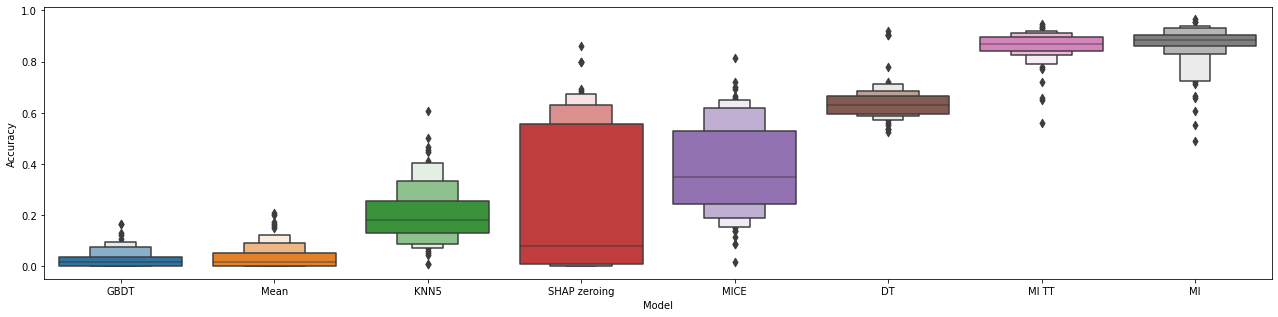

In [1100]:
import tikzplotlib
import pyperclip

plt.figure(figsize=(22, 5))
sns.boxenplot(data=results, x='model', y='score', order=grouped.index)
plt.xlabel('Model')
plt.ylabel('Accuracy')
pyperclip.copy(tikzplotlib.get_tikz_code(axis_width=r'1.4\textwidth', axis_height=r'0.55\textwidth'))
tikzplotlib.save('results/synth_boxenplots.tex', axis_width=r'1.25\textwidth', axis_height=r'0.55\textwidth')
plt.savefig('toy_data.pdf')

In [1047]:
from sklearn.multioutput import MultiOutputClassifier

In [849]:
ictcf = pd.read_pickle('../data/processed/ictcf.pkl')
for col in ictcf.select_dtypes(include=['category']).columns:
    ictcf[col] = ictcf[col].cat.codes
    ictcf.loc[ictcf[col]==-1, col] = np.nan

In [909]:
from sklearn.model_selection import train_test_split
X_train, X_test = train_test_split(ictcf.Input.Clinical)
column_imp = ColumnImputer().fit(X_train)
mean_imp = SimpleImputer(strategy='mean').fit(X_train)
Xs_train = [column_imp.transform(X_train) for i in range(120)]
ys_train = [X_train.isna() for i in range(120)]
y_test = X_test.isna()
X_test = mean_imp.transform(X_test)
estimators = []
for i in range(len(Xs_train)):
    estimators.append(MultiOutputClassifier(LGBMClassifier(n_jobs=-1)).fit(Xs_train[i].iloc[:, :30], ys_train[i].iloc[:, :30]))

In [806]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test.iloc[:, :50], np.argmax(np.mean([est.predict_proba(X_test[:, :50]) for est in estimators], axis=0), axis=2).T)

0.05249343832020997

In [937]:
from sklearn.metrics import roc_auc_score, f1_score
preds = np.mean([est.predict_proba(X_test[:, :30]) for est in estimators], axis=0)[:, :, 1]
preds_label = np.argmax(np.mean([est.predict_proba(X_test[:, :30]) for est in estimators], axis=0), axis=2)

# column_imp_perf = pd.Series([f1_score(y_test.iloc[:, i], pred) for i, pred in enumerate(preds_label)]).to_frame()
column_imp_perf = pd.Series([roc_auc_score(y_test.iloc[:, i], pred) for i, pred in enumerate(preds)]).to_frame()
column_imp_perf['model'] = 'Column Impute'

<AxesSubplot:xlabel='model', ylabel='0'>

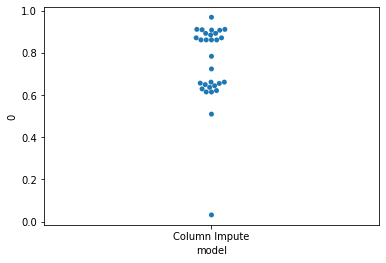

In [938]:
sns.swarmplot(data=column_imp_perf, x='model', y=0)

In [939]:
from sklearn.metrics import roc_auc_score, f1_score
# column_imp_tt_perf = pd.Series([f1_score(ys_test[0].iloc[:, i], np.random.rand(len(ys_test[0].iloc[:, i])) < X_train.iloc[:, i].isna().mean()) for i, pred in enumerate(preds)]).to_frame()
column_imp_tt_perf = pd.Series([roc_auc_score(ys_test[0].iloc[:, i], np.random.rand(len(ys_test[0].iloc[:, i]))*0.1+np.full((len(ys_test[0].iloc[:, i]), ), X_train.iloc[:, i].isna().mean())) for i, pred in enumerate(preds)]).to_frame()

column_imp_tt_perf['model'] = 'Column Impute'
column_imp_tt_perf.rename(columns={0: '0'}, inplace=True)

<AxesSubplot:xlabel='model', ylabel='0'>

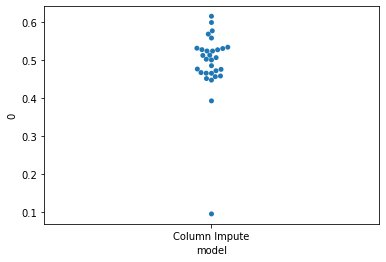

In [940]:
sns.swarmplot(data=column_imp_tt_perf, x='model', y='0')

In [876]:
from sklearn.model_selection import train_test_split
X_train, X_test = train_test_split(ictcf.Input.Clinical)
column_imp = ColumnImputer().fit(X_train)
# mean_imp = SimpleImputer(strategy='mean').fit(X_train)
Xs_train = [column_imp.transform(X_train) for i in range(20)]
ys_train = [X_train.isna() for i in range(20)]
Xs_test = [column_imp.transform(X_test) for i in range(20)]
ys_test = [X_test.isna() for i in range(20)]
estimators = []
for i in range(len(Xs_train)):
    estimators.append(MultiOutputClassifier(LGBMClassifier(n_jobs=-1)).fit(Xs_train[i].iloc[:, :20], ys_train[i].iloc[:, :20]))

In [877]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test.iloc[:, :50], np.argmax(np.mean([est.predict_proba(X_test[:, :50]) for est in estimators], axis=0), axis=2).T)

TypeError: '(slice(None, None, None), slice(None, 50, None))' is an invalid key

In [878]:
from sklearn.metrics import roc_auc_score, f1_score
preds = np.mean([est.predict_proba(Xs_test[i].iloc[:, :20]) for i, est in enumerate(estimators)], axis=0)[:, :, 1]
preds_label = np.argmax(np.mean([est.predict_proba(Xs_test[i].iloc[:, :20]) for i, est in enumerate(estimators)], axis=0), axis=2)

column_imp_tt_perf = pd.Series([f1_score(ys_test[0].iloc[:, i], pred) for i, pred in enumerate(preds_label)]).to_frame()
column_imp_tt_perf['model'] = 'Column Impute'

<AxesSubplot:xlabel='model', ylabel='0'>

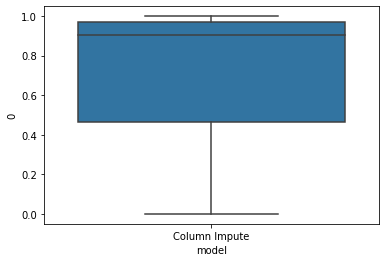

In [879]:
sns.boxplot(data=column_imp_tt_perf, x='model', y=0)

In [894]:
from sklearn.metrics import roc_auc_score, f1_score
column_imp_tt_perf = pd.Series([f1_score(ys_test[0].iloc[:, i], np.random.rand(len(ys_test[0].iloc[:, i])) < 0.5) for i, pred in enumerate(preds_label)]).to_frame()
column_imp_tt_perf['model'] = 'Column Impute'

<AxesSubplot:xlabel='model', ylabel='0'>

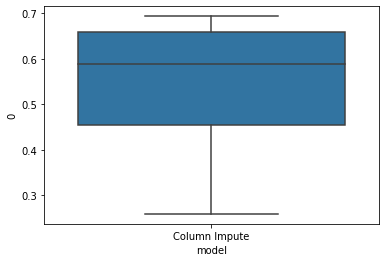

In [895]:
sns.boxplot(data=column_imp_tt_perf, x='model', y=0)

In [948]:
from sklearn.model_selection import train_test_split
X_train, X_test = train_test_split(ictcf.Input.Clinical.copy(), test_size=0.2, shuffle=True)
column_imp = ColumnImputer().fit(X_train)
# mean_imp = SimpleImputer(strategy='mean').fit(X_train)
Xs_train = [pd.DataFrame(column_imp.transform(X_train)) for i in range(100)]
ys_train = [X_train.isna() for i in range(100)]
Xs_test = [pd.DataFrame(column_imp.transform(X_test)) for i in range(100)]
ys_test = [X_test.isna() for i in range(100)]
estimator = MultiOutputClassifier(LGBMClassifier(n_jobs=-1)).fit(pd.concat(Xs_train).iloc[:, :30], pd.concat(ys_train).iloc[:, :30])
# estimators = []
# for i in range(len(Xs_train)):
#     estimators.append(MultiOutputClassifier(LGBMClassifier(n_jobs=-1)).fit(Xs_train[i].iloc[:, :20], ys_train[i].iloc[:, :20]))

In [872]:
estimator.score(pd.concat(Xs_test).iloc[:, :30], pd.concat(ys_test).iloc[:, :30])

0.13934426229508196

In [944]:
from sklearn.metrics import roc_auc_score, f1_score
preds = np.mean([estimator.predict_proba(Xs_test[i].iloc[:, :30]) for i in range(50)], axis=0)[:, :, 1]
# preds = np.array(estimator.predict_proba(pd.concat(Xs_test).iloc[:, :30]))[:, :, 1]
preds_label = np.argmax(np.mean([estimator.predict_proba(Xs_test[i].iloc[:, :30]) for i in range(50)], axis=0), axis=2)
# preds_label = np.array(estimator.predict(pd.concat(Xs_test).iloc[:, :30])).T

column_imp_tt_not_ens_perf = pd.Series([f1_score(ys_test[0].iloc[:, i], pred) for i, pred in enumerate(preds_label)]).to_frame()
column_imp_tt_not_ens_perf['model'] = 'Column Impute'

<AxesSubplot:xlabel='model', ylabel='0'>

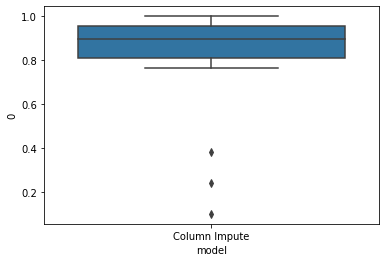

In [945]:
sns.boxplot(data=column_imp_tt_not_ens_perf, x='model', y=0)

In [946]:
from sklearn.metrics import roc_auc_score, f1_score
column_imp_tt_perf = pd.Series([f1_score(ys_test[0].iloc[:, i], np.random.rand(len(ys_test[0].iloc[:, i])) < 0.5) for i, pred in enumerate(preds_label)]).to_frame()
column_imp_tt_perf['model'] = 'Column Impute'

<AxesSubplot:xlabel='model', ylabel='0'>

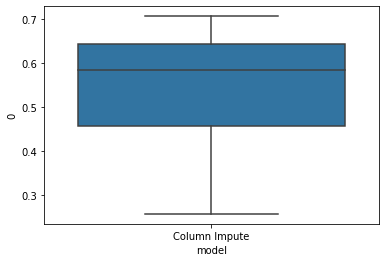

In [947]:
sns.boxplot(data=column_imp_tt_perf, x='model', y=0)

In [611]:
iter_imp = IterativeImputer(n_nearest_features=20, sample_posterior=True).fit(ictcf.Input.Clinical)
# y_isna = ictcf.Input.Clinical.isna()

In [613]:
Xs = [iter_imp.transform(ictcf.Input.Clinical) for i in range(10)]

In [615]:
ys = [ictcf.Input.Clinical.isna() for i in range(10)]

In [649]:
groups = np.concatenate([np.arange(ictcf.shape[0]) for i in range(10)])

In [658]:
from sklearn.model_selection import GroupKFold

clf = MultiOutputClassifier(LGBMClassifier(n_jobs=-1))
cross_val_score(clf, np.concatenate(Xs), np.concatenate(ys), groups=groups, cv=GroupKFold()).mean()

0.24338826574633304

In [651]:
column_imp = ColumnImputer().fit(ictcf.Input.Clinical)
# y_isna = ictcf.Input.Clinical.isna()

In [652]:
Xs_col = [column_imp.transform(ictcf.Input.Clinical) for i in range(10)]

In [653]:
ys_col = [ictcf.Input.Clinical.isna() for i in range(10)]

In [654]:
groups = np.concatenate([np.arange(ictcf.shape[0]) for i in range(10)])

In [659]:
from sklearn.model_selection import GroupKFold
clf = MultiOutputClassifier(LGBMClassifier(n_jobs=-1))
cross_val_score(clf, np.concatenate(Xs_col)[:, :50], np.concatenate(ys_col)[:, :50], groups=groups, cv=GroupKFold()).mean()

0.04260440034512512

In [1108]:
from scipy.stats import ttest_rel
from itertools import permutations
models = list(results.model.unique())
stats = []
for model_a, model_b in permutations(models, 2):
    if model_a != model_b:
        scores_a = results[results.model == model_a].score
        scores_b = results[results.model == model_b].score
        statistic, pvalue = ttest_rel(scores_a, scores_b, alternative='greater')
        stats.append({'First': model_a, 'Second': model_b, 'p': pvalue})
stats = pd.DataFrame(stats)

In [1109]:
stats.p = stats.p.apply(lambda x: f'{x:.3f}')
stats.pivot(index='First', columns='Second', values='p').fillna('-').to_latex('results/synth_pvalues.tex', caption='P-values of one-sided paired t-test between all models. ', label='tab:pvalues')

In [1102]:
def is_better_than(a, b):
    return (stats[(stats.First == a) & (stats.Second == b)].p < 0.01).item()

In [1103]:
import functools
def comp(a, b):
    a_better = is_better_than(a, b)
    b_better = is_better_than(b, a)
    return 1 if b_better else (-1 if a_better else 0)
    
is_better_than('mean', 'gbdt')

ValueError: can only convert an array of size 1 to a Python scalar

In [1104]:
ranking = pd.Series(sorted(models, key=functools.cmp_to_key(comp))).to_frame()
ranking

,0
0,MI
1,MI TT
2,DT
3,MICE
4,SHAP zeroing
5,KNN5
6,GBDT
7,Mean


In [1105]:
rank = 1
ranking['Rank'] = 1
for i in range(len(ranking)):
    ranking.loc[i, 'Rank'] = rank
    if i < len(ranking)-1 and functools.cmp_to_key(comp)(ranking.loc[i+1, 0]) > functools.cmp_to_key(comp)(ranking.loc[i, 0]):
        rank += 1

In [1106]:
ranking

,0,Rank
0,MI,1
1,MI TT,1
2,DT,2
3,MICE,3
4,SHAP zeroing,4
5,KNN5,4
6,GBDT,5
7,Mean,5


In [1107]:
ranking.set_index('Rank')[0].to_frame('Model').to_latex('results/ranking.tex', caption='Ranking of models in synthetic data. ', label='tab:synth_model_ranking')

In [191]:
pd.Series(models).apply(functools.cmp_to_key(comp))

0    <functools.KeyWrapper object at 0x00000188DE95...
1    <functools.KeyWrapper object at 0x00000188DE95...
2    <functools.KeyWrapper object at 0x00000188DE95...
3    <functools.KeyWrapper object at 0x00000188DE95...
4    <functools.KeyWrapper object at 0x00000188DE95...
dtype: object

Input                                                                \
      Clinical                                                                 
     Value_5NT Value_AFU Value_ALB Value_ALG Value_ALP Value_ALT Value_APOA1   
0          0.6       NaN    -0.015      -0.6  0.109091  1.657143         NaN   
1          0.9       NaN     0.295       0.2 -0.036364  1.285714         NaN   
2          NaN       NaN    -0.250      -1.2  0.036364  1.542857         NaN   
3          0.8       NaN    -0.165      -0.6  0.236364  0.857143         NaN   
4          NaN       NaN       NaN       NaN       NaN       NaN         NaN   
...        ...       ...       ...       ...       ...       ...         ...   
1516       0.9       NaN    -0.045      -0.8  0.172727  2.600000         NaN   
1517       NaN       NaN       NaN       NaN       NaN       NaN         NaN   
1518       NaN       NaN       NaN       NaN       NaN       NaN         NaN   
1519       NaN       NaN       NaN       NaN       NaN       NaN         NaN   
1520       NaN       NaN       NaN       NaN       NaN       NaN         NaN   

                                      ...                                \
                                      ...         Visual                  
     Value_APOB Value_APTT Value_ASO  ... vis_feature_51 vis_feature_52   
0           NaN   0.677419       NaN  ...       1.407101       0.086921   
1           NaN   1.012903       NaN  ...       5.079040       3.516342   
2           NaN        NaN       NaN  ...       0.061765      -0.239709   
3           NaN   0.696774       NaN  ...       0.878605       0.145058   
4           NaN        NaN       NaN  ...      -0.146057      -0.608026   
...         ...        ...       ...  ...            ...            ...   
1516        NaN   0.935484       NaN  ...       2.507623       0.919673   
1517        NaN        NaN       NaN  ...      -0.590748      -0.850672   
1518        NaN        NaN       NaN  ...      -0.496094      -0.825329   
1519        NaN        NaN       NaN  ...       0.111390      -0.201476   
1520        NaN        NaN       NaN  ...       1.792377       1.302997   

                                                                  \
                                                                   
     vis_feature_53 vis_feature_54 vis_feature_55 vis_feature_56   
0          0.072483       0.069505       0.051657      -0.409348   
1          3.404648       3.442693       3.337378       1.271466   
2         -0.255159      -0.260668      -0.277846      -0.393225   
3          0.107863       0.133092       0.092496      -0.333626   
4         -0.617320      -0.617773      -0.630355      -0.611461   
...             ...            ...            ...            ...   
1516       0.772426       0.912312       0.760904      -0.141144   
1517      -0.832764      -0.867031      -0.852193      -0.569649   
1518      -0.808753      -0.834399      -0.821405      -0.645694   
1519      -0.209360      -0.209015      -0.221224      -0.407458   
1520       7.887997       1.169276       0.061628      -4.302420   

                                                    Meta  
                                                  cohort  
     vis_feature_57 vis_feature_58 vis_feature_59         
0         -0.414904      -0.435154      -0.488452     c1  
1          1.221740       1.255130       1.191330     c1  
2         -0.406874      -0.414642      -0.454006     c1  
3         -0.353214      -0.352350      -0.419885     c1  
4         -0.623873      -0.624798      -0.681182     c1  
...             ...            ...            ...    ...  
1516      -0.196170      -0.162558      -0.266687     c2  
1517      -0.572261      -0.597436      -0.649602     c2  
1518      -0.645272      -0.667305      -0.714351     c2  
1519      -0.420308      -0.431136      -0.493907     c2  
1520      -4.605498      -4.470306      -0.518231     c2  

[1521 rows x 193 columns]

In [271]:
results

,model,trial,dist,score,score_train
0,dt,0,0.231232,0.842105,0.956044
1,shap_zero,0,0.231232,0.631579,0.626374
2,test_impute,0,0.231232,0.903509,1.000000
3,test_impute_random_knn4,0,0.231232,0.921053,1.000000
4,gbdt,0,0.231232,1.000000,1.000000
...,...,...,...,...,...
19,shap_zero,3,0.245992,0.552632,0.646154
20,test_impute_random,3,0.245992,0.447368,1.000000
21,test_impute_mice,3,0.245992,0.868421,1.000000
22,gbdt,3,0.245992,0.000000,1.000000


<AxesSubplot:xlabel='model', ylabel='score'>

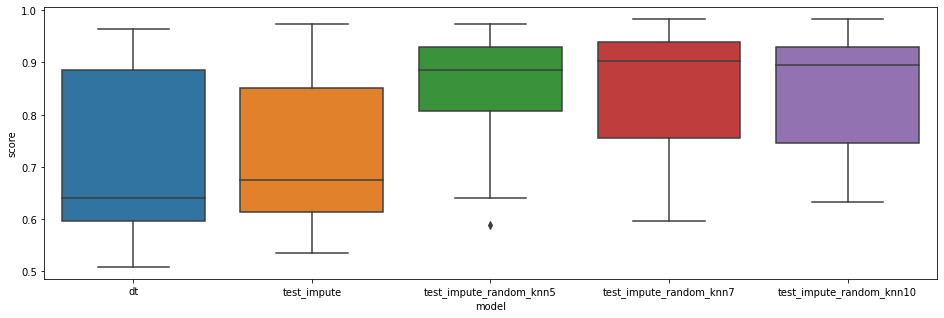

In [216]:
plt.figure(figsize=(16, 5))
sns.boxplot(data=results, x='model', y='score')

In [128]:
results

,model,trial,dist,feature,diff,score,score_train
0,zeroing_test_impute,0,0.338609,0,0.403509,0.640351,1.0
1,zeroing_test_impute,0,0.338609,1,0.000000,0.640351,1.0
2,zeroing_test_impute,0,0.338609,2,0.364835,0.640351,1.0
3,zeroing_test_impute,0,0.338609,3,0.364835,0.640351,1.0
4,zeroing_test_impute,0,0.338609,4,0.000000,0.640351,1.0
...,...,...,...,...,...,...,...
4495,zeroing_test_impute,49,0.303547,25,0.038674,0.859649,1.0
4496,zeroing_test_impute,49,0.303547,26,0.038674,0.859649,1.0
4497,zeroing_test_impute,49,0.303547,27,0.403509,0.859649,1.0
4498,zeroing_test_impute,49,0.303547,28,0.364835,0.859649,1.0


<AxesSubplot:xlabel='score', ylabel='Density'>

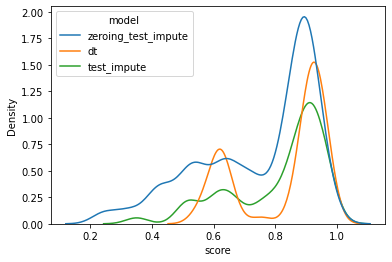

In [130]:
sns.kdeplot(data=results, x='score', hue='model')

<AxesSubplot:xlabel='score', ylabel='Density'>

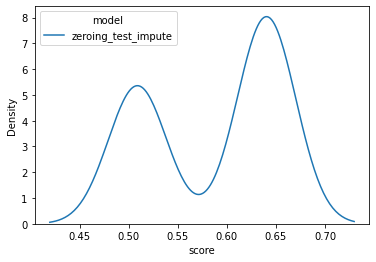

In [129]:
sns.kdeplot(data=results.iloc[:50, :], x='score', hue='model')

<AxesSubplot:xlabel='score_train', ylabel='Density'>

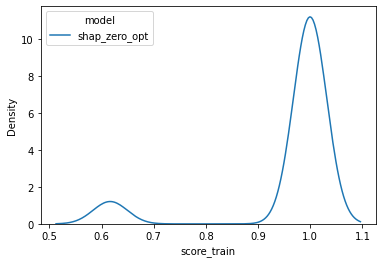

In [67]:
sns.kdeplot(data=results[results.model=='shap_zero_opt'], x='score_train', hue='model')

<AxesSubplot:xlabel='score', ylabel='Density'>

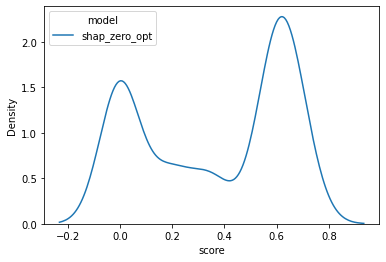

In [45]:
sns.kdeplot(data=results[results.model == 'shap_zero_opt'], x='score', hue='model')

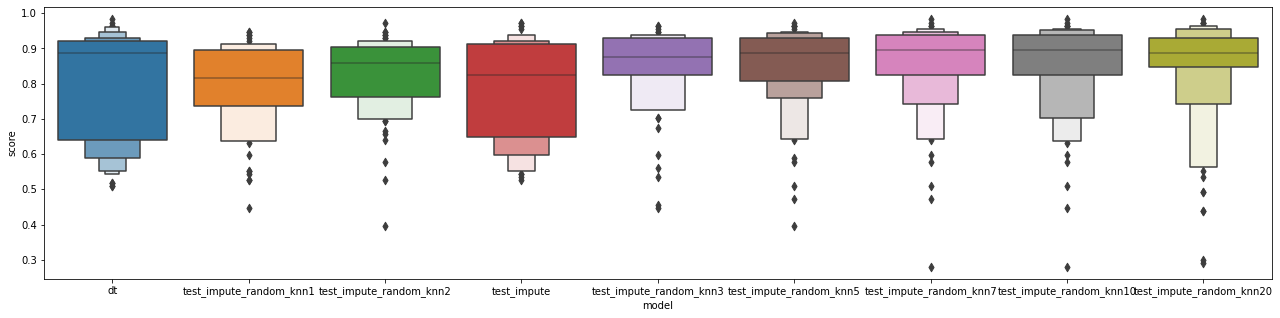

In [231]:
plt.figure(figsize=(22, 5))
sns.boxenplot(data=results, x='model', y='score')
plt.savefig('toy_data.pdf')

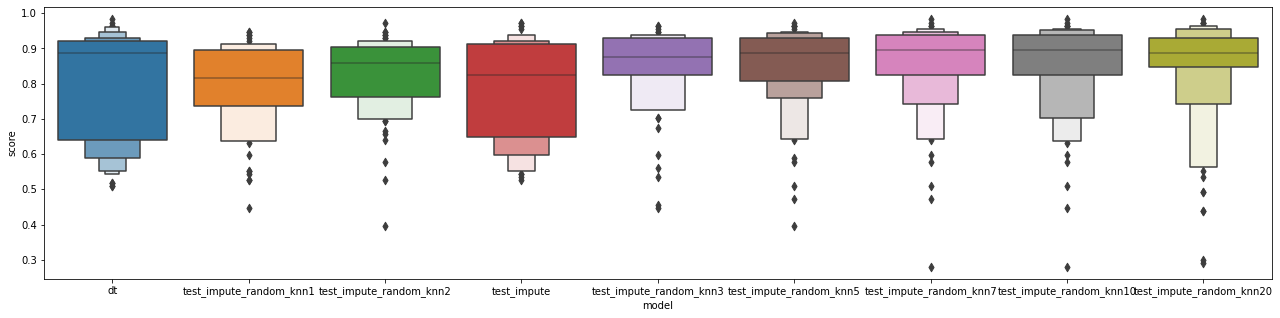

In [231]:
plt.figure(figsize=(22, 5))
sns.boxenplot(data=results, x='model', y='score')
plt.savefig('toy_data.pdf')

<AxesSubplot:xlabel='model', ylabel='score'>

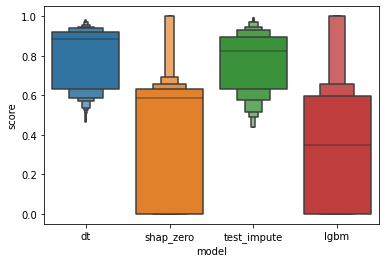

In [596]:
sns.boxenplot(data=results, x='model', y='score')

<AxesSubplot:xlabel='model', ylabel='score'>

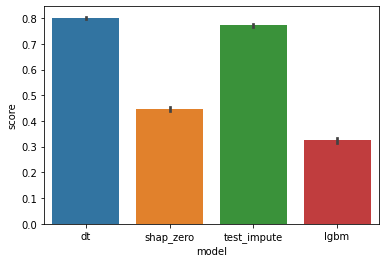

In [601]:
sns.barplot(data=results, x='model', y='score')

In [553]:
import shap
import matplotlib.pyplot as plt
import seaborn as sns
def plot_shapley(clfs, X_unimputed):
    clf_shaps = []
    for name, n, clf, X in clfs:
        if hasattr(clf, '')
        explainer = shap.TreeExplainer(clf)
        s = len(X)//n
        print(s, n, len(X))
        shaps = []
        for i in tqdm(range(n)):
            shaps.append(explainer.shap_values(X.iloc[s*i:s*(i+1), :])[1])
        print(np.array(shaps).shape)
        shaps = np.mean(shaps, axis=0)
        print(shaps.shape, X.shape)
        shap.summary_plot(shaps, features=X_unimputed)
        clf_shaps.append(pd.DataFrame({'model': name, 'missing': X_unimputed.isna().values.ravel(), 'value': shaps.ravel()}))

    clf_shaps = pd.concat(clf_shaps)
    
    plt.figure(figsize=(14, 5))
    sns.kdeplot(data=clf_shaps[clf_shaps.missing], x='value', hue='model', common_norm=False)
    plt.title('Missing shaps')
    plt.xlim(-2, 2)
    
    plt.figure(figsize=(14, 5))
    sns.kdeplot(data=clf_shaps[~clf_shaps.missing], x='value', hue='model', common_norm=False)
    plt.title('Present shaps')
    plt.xlim(-2, 2)
    
    plt.figure()
    sns.barplot(data=clf_shaps, x='model', y='value', hue='missing', estimator=lambda x: np.abs(x).mean())
#     sns.kdeplot((X.isna() * shaps).values.ravel(), label='missing')
#     sns.kdeplot(((1-X.isna()) * shaps).values.ravel(), label='present')
#     plt.legend()


In [ ]:
plot_shapley([
    ('none', 1, LGBMClassifier(n_jobs=-1), X), 
    ('column_impute', 500, ShapZeroingClassifier(LGBMClassifier(n_jobs=-1)), X_rep), 
    ('mice_impute', 80, TestTimeImputingClassifier(LGBMClassifier(n_jobs=-1), X_rep2)
], X)

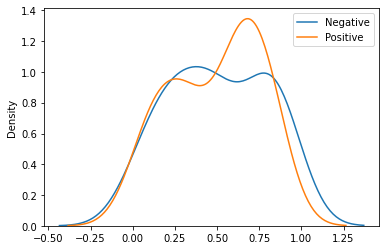

In [302]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.kdeplot(neg_pattern, label='Negative')
sns.kdeplot(pos_pattern, label='Positive')
plt.legend()

In [222]:
shap_values = clf.shap_values(X_test)

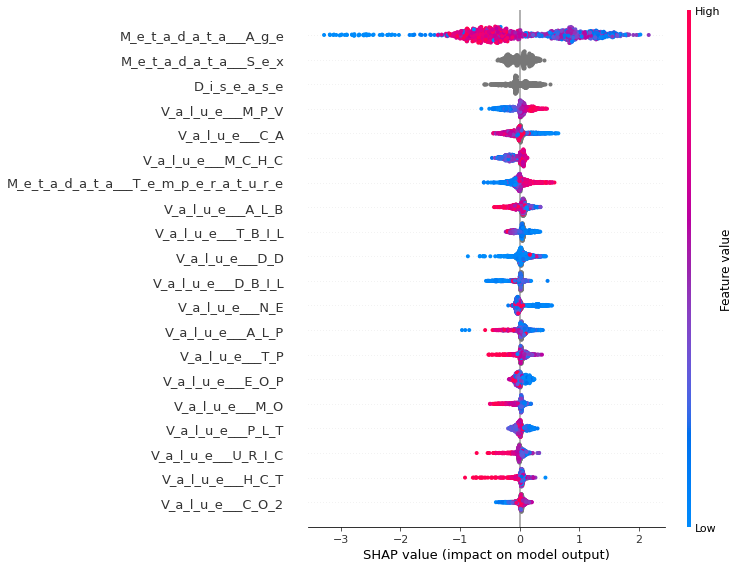

In [223]:
shap.summary_plot(shap_values[:, :, 1], features=X_test)

In [186]:
import shap
for i in range
shap.KernelExplainer(clf.predict_proba, X)

Provided model function fails when applied to the provided data set.


AttributeError: 'numpy.ndarray' object has no attribute 'columns'

In [66]:

from sklearn.impute._base import _BaseImputer
from sklearn.utils.validation import FLOAT_DTYPES
from sklearn.metrics import pairwise_distances_chunked
from sklearn.metrics.pairwise import _NAN_METRICS
from sklearn.neighbors._base import _get_weights
from sklearn.neighbors._base import _check_weights
from sklearn.utils import is_scalar_nan
from sklearn.utils._mask import _get_mask
from sklearn.utils.validation import check_is_fitted
from sklearn.utils.validation import _deprecate_positional_args

In [67]:
class KNNImputer2(_BaseImputer):
    """Imputation for completing missing values using k-Nearest Neighbors.
    Each sample's missing values are imputed using the mean value from
    `n_neighbors` nearest neighbors found in the training set. Two samples are
    close if the features that neither is missing are close.
    Read more in the :ref:`User Guide <knnimpute>`.
    .. versionadded:: 0.22
    Parameters
    ----------
    missing_values : int, float, str, np.nan or None, default=np.nan
        The placeholder for the missing values. All occurrences of
        `missing_values` will be imputed. For pandas' dataframes with
        nullable integer dtypes with missing values, `missing_values`
        should be set to np.nan, since `pd.NA` will be converted to np.nan.
    n_neighbors : int, default=5
        Number of neighboring samples to use for imputation.
    weights : {'uniform', 'distance'} or callable, default='uniform'
        Weight function used in prediction.  Possible values:
        - 'uniform' : uniform weights. All points in each neighborhood are
          weighted equally.
        - 'distance' : weight points by the inverse of their distance.
          in this case, closer neighbors of a query point will have a
          greater influence than neighbors which are further away.
        - callable : a user-defined function which accepts an
          array of distances, and returns an array of the same shape
          containing the weights.
    metric : {'nan_euclidean'} or callable, default='nan_euclidean'
        Distance metric for searching neighbors. Possible values:
        - 'nan_euclidean'
        - callable : a user-defined function which conforms to the definition
          of ``_pairwise_callable(X, Y, metric, **kwds)``. The function
          accepts two arrays, X and Y, and a `missing_values` keyword in
          `kwds` and returns a scalar distance value.
    copy : bool, default=True
        If True, a copy of X will be created. If False, imputation will
        be done in-place whenever possible.
    add_indicator : bool, default=False
        If True, a :class:`MissingIndicator` transform will stack onto the
        output of the imputer's transform. This allows a predictive estimator
        to account for missingness despite imputation. If a feature has no
        missing values at fit/train time, the feature won't appear on the
        missing indicator even if there are missing values at transform/test
        time.
    Attributes
    ----------
    indicator_ : :class:`~sklearn.impute.MissingIndicator`
        Indicator used to add binary indicators for missing values.
        ``None`` if add_indicator is False.
    References
    ----------
    * Olga Troyanskaya, Michael Cantor, Gavin Sherlock, Pat Brown, Trevor
      Hastie, Robert Tibshirani, David Botstein and Russ B. Altman, Missing
      value estimation methods for DNA microarrays, BIOINFORMATICS Vol. 17
      no. 6, 2001 Pages 520-525.
    Examples
    --------
    >>> import numpy as np
    >>> from sklearn.impute import KNNImputer
    >>> X = [[1, 2, np.nan], [3, 4, 3], [np.nan, 6, 5], [8, 8, 7]]
    >>> imputer = KNNImputer(n_neighbors=2)
    >>> imputer.fit_transform(X)
    array([[1. , 2. , 4. ],
           [3. , 4. , 3. ],
           [5.5, 6. , 5. ],
           [8. , 8. , 7. ]])
    """
    @_deprecate_positional_args
    def __init__(self, *, missing_values=np.nan, n_neighbors=5,
                 weights="uniform", metric="nan_euclidean", copy=True,
                 add_indicator=False):
        super().__init__(
            missing_values=missing_values,
            add_indicator=add_indicator
        )
        self.n_neighbors = n_neighbors
        self.weights = weights
        self.metric = metric
        self.copy = copy

    def _calc_impute(self, dist_pot_donors, n_neighbors,
                     fit_X_col, mask_fit_X_col):
        """Helper function to impute a single column.
        Parameters
        ----------
        dist_pot_donors : ndarray of shape (n_receivers, n_potential_donors)
            Distance matrix between the receivers and potential donors from
            training set. There must be at least one non-nan distance between
            a receiver and a potential donor.
        n_neighbors : int
            Number of neighbors to consider.
        fit_X_col : ndarray of shape (n_potential_donors,)
            Column of potential donors from training set.
        mask_fit_X_col : ndarray of shape (n_potential_donors,)
            Missing mask for fit_X_col.
        Returns
        -------
        imputed_values: ndarray of shape (n_receivers,)
            Imputed values for receiver.
        """
        # Get donors
        donors_idx = np.argpartition(dist_pot_donors, n_neighbors - 1,
                                     axis=1)[:, :n_neighbors]

        # Get weight matrix from from distance matrix
        donors_dist = dist_pot_donors[
            np.arange(donors_idx.shape[0])[:, None], donors_idx]

        weight_matrix = _get_weights(donors_dist, self.weights)

        # fill nans with zeros
        if weight_matrix is not None:
            weight_matrix[np.isnan(weight_matrix)] = 0.0

        # Retrieve donor values and calculate kNN average
        donors = fit_X_col.take(donors_idx)
        donors_mask = mask_fit_X_col.take(donors_idx)
        donors = np.ma.array(donors, mask=donors_mask)
        
#         print(donors.shape)
#         print(np.ma.average(donors, axis=1, weights=weight_matrix).data)

#         return np.ma.average(donors, axis=1, weights=weight_matrix).data
        return donors[:, np.random.choice(donors.shape[1])]

    def fit(self, X, y=None):
        """Fit the imputer on X.
        Parameters
        ----------
        X : array-like shape of (n_samples, n_features)
            Input data, where `n_samples` is the number of samples and
            `n_features` is the number of features.
        Returns
        -------
        self : object
        """
        # Check data integrity and calling arguments
        if not is_scalar_nan(self.missing_values):
            force_all_finite = True
        else:
            force_all_finite = "allow-nan"
            if self.metric not in _NAN_METRICS and not callable(self.metric):
                raise ValueError(
                    "The selected metric does not support NaN values")
        if self.n_neighbors <= 0:
            raise ValueError(
                "Expected n_neighbors > 0. Got {}".format(self.n_neighbors))

        X = self._validate_data(X, accept_sparse=False, dtype=FLOAT_DTYPES,
                                force_all_finite=force_all_finite,
                                copy=self.copy)

        _check_weights(self.weights)
        self._fit_X = X
        self._mask_fit_X = _get_mask(self._fit_X, self.missing_values)

        super()._fit_indicator(self._mask_fit_X)

        return self

    def transform(self, X):
        """Impute all missing values in X.
        Parameters
        ----------
        X : array-like of shape (n_samples, n_features)
            The input data to complete.
        Returns
        -------
        X : array-like of shape (n_samples, n_output_features)
            The imputed dataset. `n_output_features` is the number of features
            that is not always missing during `fit`.
        """

        check_is_fitted(self)
        if not is_scalar_nan(self.missing_values):
            force_all_finite = True
        else:
            force_all_finite = "allow-nan"
        X = self._validate_data(X, accept_sparse=False, dtype=FLOAT_DTYPES,
                                force_all_finite=force_all_finite,
                                copy=self.copy, reset=False)

        mask = _get_mask(X, self.missing_values)
        mask_fit_X = self._mask_fit_X
        valid_mask = ~np.all(mask_fit_X, axis=0)

        X_indicator = super()._transform_indicator(mask)

        # Removes columns where the training data is all nan
        if not np.any(mask):
            # No missing values in X
            # Remove columns where the training data is all nan
            return X[:, valid_mask]

        row_missing_idx = np.flatnonzero(mask.any(axis=1))

        non_missing_fix_X = np.logical_not(mask_fit_X)

        # Maps from indices from X to indices in dist matrix
        dist_idx_map = np.zeros(X.shape[0], dtype=int)
        dist_idx_map[row_missing_idx] = np.arange(row_missing_idx.shape[0])

        def process_chunk(dist_chunk, start):
            row_missing_chunk = row_missing_idx[start:start + len(dist_chunk)]

            # Find and impute missing by column
            for col in range(X.shape[1]):
                if not valid_mask[col]:
                    # column was all missing during training
                    continue

                col_mask = mask[row_missing_chunk, col]
                if not np.any(col_mask):
                    # column has no missing values
                    continue

                potential_donors_idx, = np.nonzero(non_missing_fix_X[:, col])

                # receivers_idx are indices in X
                receivers_idx = row_missing_chunk[np.flatnonzero(col_mask)]

                # distances for samples that needed imputation for column
                dist_subset = (dist_chunk[dist_idx_map[receivers_idx] - start]
                               [:, potential_donors_idx])

                # receivers with all nan distances impute with mean
                all_nan_dist_mask = np.isnan(dist_subset).all(axis=1)
                all_nan_receivers_idx = receivers_idx[all_nan_dist_mask]

                if all_nan_receivers_idx.size:
                    col_mean = np.ma.array(self._fit_X[:, col],
                                           mask=mask_fit_X[:, col]).mean()
                    X[all_nan_receivers_idx, col] = col_mean

                    if len(all_nan_receivers_idx) == len(receivers_idx):
                        # all receivers imputed with mean
                        continue

                    # receivers with at least one defined distance
                    receivers_idx = receivers_idx[~all_nan_dist_mask]
                    dist_subset = (dist_chunk[dist_idx_map[receivers_idx]
                                              - start]
                                   [:, potential_donors_idx])

                n_neighbors = min(self.n_neighbors, len(potential_donors_idx))
                value = self._calc_impute(
                    dist_subset,
                    n_neighbors,
                    self._fit_X[potential_donors_idx, col],
                    mask_fit_X[potential_donors_idx, col])
                X[receivers_idx, col] = value

        # process in fixed-memory chunks
        gen = pairwise_distances_chunked(
            X[row_missing_idx, :],
            self._fit_X,
            metric=self.metric,
            missing_values=self.missing_values,
            force_all_finite=force_all_finite,
            reduce_func=process_chunk)
        for chunk in gen:
            # process_chunk modifies X in place. No return value.
            pass
        
        return super()._concatenate_indicator(X[:, valid_mask], X_indicator)

In [204]:
KNNImputer2().fit_transform(np.array([
    [1, 1, np.nan], 
    [np.nan, np.nan, -2],
    [1, 0, -2],
    [1, 1, -2],
    [1, 1, -2],
    [1, 1, -2],
    [1, 1, -2],
    [1, 5, -2],
    [1, 5, -2]
    
]))

(1, 5)
[1.]
(1, 5)
[2.6]
(1, 5)
[-2.]


array([[ 1.,  1., -2.],
       [ 1.,  1., -2.],
       [ 1.,  0., -2.],
       [ 1.,  1., -2.],
       [ 1.,  1., -2.],
       [ 1.,  1., -2.],
       [ 1.,  1., -2.],
       [ 1.,  5., -2.],
       [ 1.,  5., -2.]])

In [197]:
from tqdm import tqdm
def repeated_impute(X, y, imputer, should_fit, n=100):
    X_rep = []
    y_rep = []
    
    if should_fit:
        imputer.fit(X)
        
    for i in tqdm(range(n)):
        X_rep.append(imputer.transform(X))
        y_rep.append(y)
    
    X_rep = pd.concat([pd.DataFrame(x) for x in X_rep])
    y_rep = pd.concat(y_rep)
    return X_rep, y_rep

In [ ]:
from sklearn.impute import SimpleImputer
Xs = []
ys = []
imputer = SimpleImputer()
imputer.fit(X)
for i in range(self.n_repeat):
    Xs.append()

In [535]:
from sklearn.base import clone as estimator_clone

class MultiOutputClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, base_estimator):
        self.base_estimator = base_estimator
        self._estimators = []
    
    def fit(self, X, y):
        self.classes_ = np.unique(y)
        for col in y.columns:
            estimator = estimator_clone(self.base_estimator)
            estimator.fit(X, y[col])
            self._estimators.append(estimator)
        
    def predict(self, X):
        result = np.stack([np.argmax(pred, axis=1).astype(bool) for pred in clf.predict_proba(imputer.transform(X_test))]).T
        return result
    
    def predict_proba(self, X):
        preds_list = [estimator.predict_proba(X) for estimator in self._estimators]
        return preds_list

In [536]:
clf = MultiOutputClassifier(LGBMClassifier(n_jobs=-1))

In [537]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer()
imputer.fit(X_train)
clf.fit(imputer.transform(X_train), X_train.isna())

In [532]:
from sklearn.ensemble import RandomForestClassifier
RandomForestClassifier().fit(imputer.transform(X_train), X_train.isna()).score(imputer.transform(X_test), X_test.isna())

0.0017761989342806395

In [529]:
clf.score(imputer.transform(X_test), X_test.isna())

0.0

In [538]:
from sklearn.metrics import accuracy_score, recall_score
preds = clf.predict(imputer.transform(X_test))
np.mean([accuracy_score(X_test.isna().iloc[:, i], preds[:, i]) for i in range(preds.shape[1])])
np.mean([recall_score(X_test.isna().iloc[:, i], preds[:, i]) for i in range(preds.shape[1])])



Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.


0.7328142846692226

In [530]:
preds.isna()

,V_a_l_u_e___5_N_T,V_a_l_u_e___A_F_U,V_a_l_u_e___A_L_B,V_a_l_u_e___A_L_G,V_a_l_u_e___A_L_P,V_a_l_u_e___A_L_T,V_a_l_u_e___A_P_O_A_1,V_a_l_u_e___A_P_O_B,V_a_l_u_e___A_P_T_T,V_a_l_u_e___A_S_O,V_a_l_u_e___A_S_T,V_a_l_u_e___A_T_3,V_a_l_u_e___A_n_G,V_a_l_u_e___B_A,V_a_l_u_e___B_A_C_T,V_a_l_u_e___B_A_P,V_a_l_u_e___B_C,V_a_l_u_e___B_N_P,V_a_l_u_e___B_U_N,V_a_l_u_e___B_Y_S_T,V_a_l_u_e___C_1_q,V_a_l_u_e___C_3,V_a_l_u_e___C_4,V_a_l_u_e___C_A,V_a_l_u_e___C_D_3_+,V_a_l_u_e___C_D_4_+,V_a_l_u_e___C_D_4_/_C_D_8,V_a_l_u_e___C_D_8_+,V_a_l_u_e___C_H_E,V_a_l_u_e___C_H_O_L,V_a_l_u_e___C_K,V_a_l_u_e___C_L,V_a_l_u_e___C_O_2,V_a_l_u_e___C_R_E_A,V_a_l_u_e___C_R_P,V_a_l_u_e___C_y_s_C,V_a_l_u_e___D_B_I_L,V_a_l_u_e___D_D,V_a_l_u_e___E_O,V_a_l_u_e___E_O_P,V_a_l_u_e___E_S_R,V_a_l_u_e___F_D_G,V_a_l_u_e___F_D_P,V_a_l_u_e___F_I_B,V_a_l_u_e___G_G_T,V_a_l_u_e___G_L_B,V_a_l_u_e___G_L_U,V_a_l_u_e___H_B_D_H,...,V_a_l_u_e___M_P_V,V_a_l_u_e___M_S_-_U,V_a_l_u_e___N_E,V_a_l_u_e___N_E_P,V_a_l_u_e___N_K_C,V_a_l_u_e___N_S_E_C,V_a_l_u_e___N_a,V_a_l_u_e___O_S_M,V_a_l_u_e___P_A,V_a_l_u_e___P_C_T,V_a_l_u_e___P_D_W,V_a_l_u_e___P_H,V_a_l_u_e___P_H_O_S,V_a_l_u_e___P_L_C_R,V_a_l_u_e___P_L_C_T,V_a_l_u_e___P_L_T,V_a_l_u_e___P_T,V_a_l_u_e___R_B_C,V_a_l_u_e___R_D_W_C_V,V_a_l_u_e___R_D_W_S_D,V_a_l_u_e___R_F,V_a_l_u_e___S_A,V_a_l_u_e___S_A_A,V_a_l_u_e___S_G,V_a_l_u_e___S_Q_E_P,V_a_l_u_e___S_d_L_D_L,V_a_l_u_e___T_B_A,V_a_l_u_e___T_B_I_L,V_a_l_u_e___T_G,V_a_l_u_e___T_N_F,V_a_l_u_e___T_P,V_a_l_u_e___T_T,V_a_l_u_e___U,V_a_l_u_e___U_A_L_B,V_a_l_u_e___U_N_C_C,V_a_l_u_e___U_N_C_X,V_a_l_u_e___U_R_B_C,V_a_l_u_e___U_R_I_C,V_a_l_u_e___U_W_B_C,V_a_l_u_e___W_B_C,V_a_l_u_e___W_B_C_C,M_e_t_a_d_a_t_a___A_g_e,M_e_t_a_d_a_t_a___S_e_x,M_e_t_a_d_a_t_a___T_e_m_p_e_r_a_t_u_r_e,D_i_s_e_a_s_e___h_y_p_e_r_t_e_n_s_i_o_n,D_i_s_e_a_s_e___d_i_a_b_e_t_e_s,D_i_s_e_a_s_e___c_o_r_o_n_a_r_y_ _a_t_h_e_r_o_s_c_l_e_r_o_t_i_c_ _h_e_a_r_t_ _d_i_s_e_a_s_e,D_i_s_e_a_s_e
0,False,True,False,False,False,False,True,True,False,True,False,True,False,False,True,False,False,True,False,True,True,True,True,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,True,False,False,False,False,False,...,False,True,False,False,False,True,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,True,False,True,True,False,False,False,False,False,False,False,True,True,True,True,True,False,True,False,True,False,False,False,False,False,False,False
1,False,True,False,False,False,False,True,True,False,True,False,True,False,False,True,False,True,True,False,True,True,True,True,False,True,True,True,True,True,False,False,False,False,False,False,False,False,False,False,False,False,True,True,False,False,False,False,False,...,False,True,False,False,True,True,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,True,False,True,True,False,False,False,False,False,False,False,True,True,True,True,True,False,True,False,True,False,False,False,False,False,False,False
2,True,True,False,False,False,False,True,True,True,True,False,True,False,False,True,False,True,True,False,True,True,True,True,False,True,True,True,True,True,False,False,False,False,False,False,False,False,True,False,False,True,True,True,True,False,False,False,False,...,False,True,False,False,True,True,False,False,False,True,False,True,False,True,False,False,True,False,True,True,True,True,True,True,True,True,False,False,False,True,False,True,True,True,True,True,True,False,True,False,True,False,False,False,False,False,False,False
3,False,True,False,False,False,False,True,True,False,True,False,True,False,False,True,False,False,True,False,True,True,True,True,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,True,False,False,False,False,False,...,False,True,False,False,False,True,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,True,False,True,True,False,False,False,False,False,False,

In [489]:
imputer.transform(X_train).shape, imputer.transform(X_test).shape

((395, 106), (1126, 106))

In [491]:
X_train.isna().shape, X_test.isna().shape

((395, 127), (1126, 127))

In [1023]:
from sklearn.datasets import load_breast_cancer
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
X_breast, y_breast = load_breast_cancer(return_X_y=True)
X_breast_train, X_breast_test, y_breast_train, y_breast_test = train_test_split(X_breast, y_breast, test_size=0.2)

In [1024]:
clf_svc = SVC(probability=True).fit(X_breast_train, y_breast_train)
clf_dtc = RandomForestClassifier().fit(X_breast_train, y_breast_train)

In [3]:
import os
os.environ['PATH'] += r';C:\Program Files\R\R-4.0.3\bin'

In [546]:
!Rscript -e "install.packages('jsonlite', repos='https://cloud.r-project.org/', lib = .Library)"

Warning in install.packages("jsonlite", repos = "https://cloud.r-project.org/",  :
  'lib = "C:/PROGRA~1/R/R-40~1.3/library"' is not writable
Error in install.packages("jsonlite", repos = "https://cloud.r-project.org/",  : 
  unable to install packages
Execution halted


In [547]:
!pip install r-functions

You should consider upgrading via the 'c:\users\roel\.virtualenvs\diagcovid-ckc2berq\scripts\python.exe -m pip install --upgrade pip' command.


In [1021]:
from r_functions import create, run

In [1020]:
add = create('test.r', 'add')

NameError: name 'create' is not defined

In [1025]:
preds_svc = clf_svc.predict_proba(X_breast_test)[:, 1]
preds_dtc = clf_dtc.predict_proba(X_breast_test)[:, 1]

In [1026]:
from rpy2.robjects.packages import importr, data

In [1027]:
pROC = importr('pROC')

In [1034]:
y_breast_test.shape

(114,)

In [1028]:
from rpy2.robjects import numpy2ri
numpy2ri.activate()
roc_svc = pROC.roc(y_breast_test, preds_svc)
roc_dtc = pROC.roc(y_breast_test, preds_dtc)
roc_test_result = pROC.roc_test(roc_dtc, roc_svc, alternative='less')
numpy2ri.deactivate()

In [1029]:
import numpy as np
for k, v in roc_test_result.items():
    if k == 'p.value':
        print(np.array(v).item())

0.966198141513145


In [32]:
import pandas as pd
df_rumc = pd.read_pickle('../data/processed/rumc.pkl')

In [35]:
df_rumc[~df_rumc.Target.pcr.isna() & (df_rumc.Meta.part == 'test')]

Input                           \
                                    Clinical                            
                        (PSEUDO) PELGER HUET (PSEUDO) PELGER HUET CHL   
patientprimarymrn study                                                 
10008             st000                  NaN                      NaN   
10017             st000                  NaN                      NaN   
10025             st000                  NaN                      NaN   
10033             st000                  NaN                      NaN   
10051             st000                  NaN                      NaN   
10056             st000                  NaN                      NaN   
10059             st000                  NaN                      NaN   
10066             st000                  NaN                      NaN   
10070             st000                  NaN                      NaN   
10096             st000                  NaN                      NaN   
10099             st000                  NaN                      NaN   
10101             st001                  NaN                      NaN   
10109             st001                  NaN                      NaN   
10124             st000                  NaN                      NaN   
10137             st000                  NaN                      NaN   
10143             st000                  NaN                      NaN   
10147             st000                  NaN                      NaN   
10156             st002                  1.0                      NaN   
10157             st000                  NaN                      NaN   
10182             st000                  NaN                      NaN   
10183             st001                  NaN                      NaN   
10186             st001                  NaN                      NaN   

                                                              \
                                                               
                        3-METHOXYTYRAMINE 5-HIAA (24U URINE)   
patientprimarymrn study                                        
10008             st000               NaN                NaN   
10017             st000               NaN                NaN   
10025             st000               NaN                NaN   
10033             st000               NaN                NaN   
10051             st000               NaN                NaN   
10056             st000               NaN                NaN   
10059             st000               NaN                NaN   
10066             st000               NaN                NaN   
10070             st000               NaN                NaN   
10096             st000               NaN                NaN   
10099             st000               NaN                NaN   
10101             st001               NaN                NaN   
10109             st001               NaN                NaN   
10124             st000               NaN                NaN   
10137             st000               NaN                NaN   
10143             st000               NaN                NaN   
10147             st000               NaN                NaN   
10156             st002               NaN                NaN   
10157             st000               NaN                NaN   
10182             st000               NaN                NaN   
10183             st001               NaN                NaN   
10186             st001               NaN                NaN   

                                                              \
                                                               
                        6-MMPR (AZATHIOPRINE/MERCAPTOPURINE)   
patientprimarymrn study                                        
10008             st000                                  NaN   
10017             st000                                  NaN   
10025             st000                                  NaN   
10033             st000    